# Feature difference analysis

Here, we try to systematically find the differences between synapses induced by different antibodies

In [1]:
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.utils import shuffle
import skimage
plt.ion()   # interactive mode
from skimage.transform import   rescale, resize 
import random
#import umap
from tqdm import tqdm
from random import sample
from skimage.transform import resize
import h5py
from skimage.exposure import rescale_intensity
import seaborn as sns
from umap import UMAP


2023-10-11 19:57:11.303355: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 19:57:11.305307: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-11 19:57:11.348992: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-11 19:57:11.350175: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 19:57:12.790797: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
from difflib import SequenceMatcher
def similar(a,b):
    return SequenceMatcher(None, a,b).ratio()




def check_feature_type(features, feature_dict, channels= ["_BF"]):
    features_series = pd.DataFrame(features, 
                                   columns = ["feature"] )
    features_series["feature_type"] = np.nan
    features_series["channel_1"] = np.nan
    features_series["channel_2"] = np.nan
    
    for i,f in enumerate(features):
        similarity_score = []
        for k in feature_dict:
            similarity_score.append(similar(f,k))
        closest_key = np.array(similarity_score).argmax()
        closest_key = list(feature_dict.keys())[closest_key]
        features_series.loc[i,"feature_type"] = feature_dict[closest_key]

            
        for j , ch1 in enumerate(channels):
            if ch1 in f:
                features_series["channel_1"].iloc[i] = ch1
                for ch2 in channels[(j+1):]:
                    if ch2 in f:
                        features_series["channel_2"].iloc[i] = ch2
                        break
                break
        
            
    return features_series



In [3]:
def check_consistency_in_experiments(metadata_p_values, experiments = ["Experiment_1"]):
    metadata_p_values_ = metadata_p_values.T.copy()
    significance = np.array([0.]*metadata_p_values_.shape[0])
    for exp in experiments:
        col_index = metadata_p_values_.columns.str.contains(exp)
        significance += metadata_p_values_.loc[:,col_index].abs().sum(1) > 0
    significance = (significance  >= len(experiments) - 1.)
    return significance


In [4]:
from skimage.util import crop

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w


here is the list of channels and features

In [5]:
channels = ["_BF","_F-Actin","_MHCII","_CD3","_P-CD3zeta","_Antibody"]


In [6]:
feature_dict = {'mask_based_area': "morphology",
'mask_based_bbox_area': "morphology",
'mask_based_convex_area': "morphology",
'mask_based_eccentricity': "morphology",
'mask_based_equivalent_diameter': "morphology",
'mask_based_euler_number': "morphology",
'mask_based_extent': "morphology",
'mask_based_feret_diameter_max': "morphology",
'mask_based_filled_area': "morphology",
'mask_based_major_axis_length': "morphology",
'mask_based_max_intensity': "morphology",
'mask_based_mean_intensity': "intensity statistics",
'mask_based_min_intensity': "intensity statistics",
'mask_based_minor_axis_length':"morphology",
'mask_based_moments_hu-0':"morphology",
'mask_based_moments_hu-1':"morphology",
'mask_based_moments_hu-2':"morphology",
'mask_based_moments_hu-3':"morphology",
'mask_based_moments_hu-4':"morphology",
'mask_based_moments_hu-5':"morphology",
'mask_based_moments_hu-6':"morphology",
'mask_based_orientation':"morphology",
'mask_based_perimeter':"morphology",
'mask_based_perimeter_crofton':"morphology",
'mask_based_solidity':"morphology",
'mask_based_weighted_moments_hu-0':"morphology",
'mask_based_weighted_moments_hu-1':"morphology",
'mask_based_weighted_moments_hu-2':"morphology",
'mask_based_weighted_moments_hu-3':"morphology",
'mask_based_weighted_moments_hu-4':"morphology",
'mask_based_weighted_moments_hu-5':"morphology",
'mask_based_weighted_moments_hu-6':"morphology",
'contrast': "texture",
'dissimilarity': "texture",
'homogeneity': "texture",
'ASM': "texture",
'energy': "texture",
'correlation': "texture",
'gradient_RMS': "sanity",
'background_mean': "sanity",
'percentile_10': "intensity statistics",
'percentile_20': "intensity statistics",
'percentile_30': "intensity statistics",
'percentile_40': "intensity statistics",
'percentile_50': "intensity statistics",
'percentile_60': "intensity statistics",
'percentile_70': "intensity statistics",
'percentile_80': "intensity statistics",
'percentile_90': "intensity statistics",
'Area': "morphology",
'sum_intensity': "intensity statistics",
'mean_intensity': "intensity statistics",
'std_intensity': "intensity statistics",
'kurtosis_intensity': "intensity statistics",
'skew_intensity': "intensity statistics",
'min_intensity': "intensity statistics",
'max_intensity': "intensity statistics",
'shannon_entropy': "intensity statistics",
'jaccard_distance': "colocalization",
'dice_distance': "colocalization",
'correlation_distance': "colocalization",
'euclidean_distance': "colocalization",
'manders_overlap_coefficient': "colocalization",
'intensity_correlation_quotient': "colocalization",
'structural_similarity': "colocalization",
'sum_intensity_ratio': "synaptic feature",
'mean_intensity_ratio': "synaptic feature",
'max_intensity_ratio': "synaptic feature",
'cell_distance': "colocalization",
'weighted_cell_distance': "colocalization"}


lets load the data

In [7]:
metadata = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/metadata_subset_with_predictions.csv.gz")
metadata


,file,experiment,donor,condition,object_number,set,label,prediction,entropy,key,outlier,cluster
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,5156,unlabeled,-1,B_cell,0.001350,Experiment_1 Donor_1,False,0
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,32020,unlabeled,-1,T_cell,0.000959,Experiment_1 Donor_1,False,1
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,55974,unlabeled,-1,Dead_Cell,0.002358,Experiment_1 Donor_1,False,0
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,15150,unlabeled,-1,T_cell,0.000502,Experiment_1 Donor_1,False,1
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,44814,unlabeled,-1,B_cell_with_small_area,0.028317,Experiment_1 Donor_1,False,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1065962,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,72493,unlabeled,-1,T_cell_with_signaling,0.259178,Experiment_4 Donor_9,False,1
1065963,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,106656,unlabeled,-1,B_cell,0.006382,Experiment_4 Donor_9,False,0
1065964,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,110990,unlabeled,-1,T_cell_with_signaling,0.487638,Experiment_4 Donor_9,False,1
1065965,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,71451,unlabeled,-1,B_cell,0.082181,Experiment_4 Donor_9,False,2


In [8]:
indx = metadata.outlier.astype(str) == "True"
metadata.loc[indx, "outlier"] = 1
metadata.loc[~indx, "outlier"] = 0
metadata["outlier"] = metadata["outlier"].astype(int)


In [9]:

df_features = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/df_features_subset.csv.gz")
df_features


,mask_based_area_BF,mask_based_bbox_area_BF,mask_based_convex_area_BF,mask_based_eccentricity_BF,mask_based_equivalent_diameter_BF,mask_based_euler_number_BF,mask_based_extent_BF,mask_based_feret_diameter_max_BF,mask_based_filled_area_BF,mask_based_major_axis_length_BF,...,max_intensity_ratio_MHCII_R7_R8,sum_intensity_ratio_CD3_R7_R8,mean_intensity_ratio_CD3_R7_R8,max_intensity_ratio_CD3_R7_R8,sum_intensity_ratio_P-CD3zeta_R7_R8,mean_intensity_ratio_P-CD3zeta_R7_R8,max_intensity_ratio_P-CD3zeta_R7_R8,sum_intensity_ratio_Live-Dead_R7_R8,mean_intensity_ratio_Live-Dead_R7_R8,max_intensity_ratio_Live-Dead_R7_R8
0,2228,3021,2392,0.484394,53.261409,1,0.737504,61.717096,2228,57.336477,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,885,1155,925,0.238094,33.568095,1,0.766234,36.138622,885,34.216438,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,656,812,689,0.369856,28.900608,1,0.807882,32.756679,656,30.262314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,753,899,780,0.386491,30.963678,1,0.837597,34.132096,753,32.348559,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1208,1512,1247,0.661747,39.218279,1,0.798942,51.224994,1208,45.782110,...,19.735296,0.465222,0.465222,25.504583,0.481531,0.481531,26.397369,0.754085,0.754085,45.835530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065962,973,1190,997,0.100885,35.197473,1,0.817647,37.215588,973,35.332773,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1065963,3956,5046,4180,0.787555,70.971372,1,0.783987,91.760558,3956,91.437834,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1065964,909,1073,928,0.622298,34.020211,1,0.847158,40.804412,909,38.830446,...,5.716450,0.190820,0.190820,7.474995,0.115499,0.115499,4.191402,1.000000,1.000000,32.928658
1065965,3388,4272,3670,0.875994,65.679035,1,0.793071,90.426766,3388,96.830707,...,6.247939,0.039196,0.039196,124.378412,0.045108,0.045108,140.202637,0.005466,0.005466,16.385927


In [10]:
list_of_features_to_exclude = ["Antibody","Live-Dead","CD18",  "_R2",  "_R3",  "_R8", "background",
                               "moment","percent","mask_based_mean","mask_based_min","mask_based_max",  
                               "RMS","intensity_BF","_R1_R2","_R1_R3","_R1_R4","_R1_R5","_R1_R6","_R1_R7",
                               "_R1_R8","_R2_R1","_R2_R3","_R2_R4","_R2_R5","_R2_R6","_R2_R7","_R2_R8",
                               "_R3_R1","_R3_R2","_R3_R4","_R3_R5","_R3_R6","_R3_R7","_R3_R8",
                               "_R4_R1","_R4_R2","_R4_R3","_R4_R5","_R4_R6","_R4_R7","_R4_R8",
                               "_R5_R1","_R5_R2","_R5_R3","_R5_R4","_R5_R6","_R5_R8","_R6_R1","_R6_R2",
                               "_R6_R3","_R6_R4","_R6_R5","_R6_R7","_R6_R8","_R7_R1","_R7_R2",
                               "_R7_R3","_R7_R4","_R7_R5","_R7_R6","_R7_R8","_R8_R1","_R8_R2",
                               "_R8_R3","_R8_R4","_R8_R5","_R8_R6","_R8_R7","cell_distance"]
classification_indx = ~df_features.columns.str.contains( list_of_features_to_exclude[0]) 

for f_to_exclude in list_of_features_to_exclude:
    classification_indx = classification_indx & ~df_features.columns.str.contains( f_to_exclude) 
    

print("list of remained columns:\n", 
      df_features.columns[classification_indx],
     "\n",
     "so we have these many columns:",
     classification_indx.sum())


list of remained columns:
 Index(['mask_based_area_BF', 'mask_based_bbox_area_BF',
       'mask_based_convex_area_BF', 'mask_based_eccentricity_BF',
       'mask_based_equivalent_diameter_BF', 'mask_based_euler_number_BF',
       'mask_based_extent_BF', 'mask_based_feret_diameter_max_BF',
       'mask_based_filled_area_BF', 'mask_based_major_axis_length_BF',
       ...
       'max_intensity_ratio_F-Actin_R5_R7', 'sum_intensity_ratio_MHCII_R5_R7',
       'mean_intensity_ratio_MHCII_R5_R7', 'max_intensity_ratio_MHCII_R5_R7',
       'sum_intensity_ratio_CD3_R5_R7', 'mean_intensity_ratio_CD3_R5_R7',
       'max_intensity_ratio_CD3_R5_R7', 'sum_intensity_ratio_P-CD3zeta_R5_R7',
       'mean_intensity_ratio_P-CD3zeta_R5_R7',
       'max_intensity_ratio_P-CD3zeta_R5_R7'],
      dtype='object', length=235) 
 so we have these many columns: 235


In [11]:
set_of_interesting_classes = ['B_cell',  'T_cell', 
                        'T_cell_with_signaling',
                        'T_cell_with_B_cell_fragments',
                        'B_T_cell_in_one_layer',
                        'Synapses_without_signaling', 
                        'Synapses_with_signaling',
                        'No_cell_cell_interaction', 
                        'Multiplets'] 


# Analysis of difference of synapses in Teplizumab vs isotype 

In [12]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

key_order = [ 'Experiment_1 Donor_1',
             'Experiment_1 Donor_2',
             'Experiment_2 Donor_3',
             'Experiment_2 Donor_4',
             'Experiment_3 Donor_1',
             'Experiment_3 Donor_5',
             'Experiment_3 Donor_6']

most_important_features =  df_features.columns[classification_indx]  
metadata_p_values = pd.DataFrame(columns= most_important_features)
metadata_feature_direction = pd.DataFrame(columns= most_important_features)

for k in key_order: 
    indx = metadata["key"] == k
    indx = indx&(metadata["prediction"].isin([ "Synapses_with_signaling"])) 
    indx = indx&(metadata["outlier"].isin([0])) 
    indx_isotype = indx&(metadata["condition"] == "Isotype")
    indx_teplizumab = indx&(metadata["condition"] == 'Teplizumab')


    if indx_isotype.sum()*indx_teplizumab.sum():
        print(k)
        print("indx_isotype", indx_isotype.sum())
        print("indx_teplizumab", indx_teplizumab.sum())
        new_p_row = dict()
        new_feature_direction = dict()
        for col in most_important_features:
            xx = df_features.loc[indx_isotype , col].tolist()
            yy = df_features.loc[indx_teplizumab , col].tolist()
            
            try:
                new_p_row[col] = stats.mannwhitneyu(xx, yy).pvalue
                
            except ValueError:
                new_p_row[col] = 1.
                
            new_feature_direction[col] = np.sign(np.median(yy) - np.median(xx))
        new_p_row = pd.DataFrame(new_p_row, index = [0])       
        new_feature_direction = pd.DataFrame(new_feature_direction, index = [0])       
        metadata_p_values = pd.concat([metadata_p_values, new_p_row]).reset_index(drop=True)
        metadata_feature_direction = pd.concat([metadata_feature_direction, new_feature_direction]).reset_index(drop=True)


Experiment_1 Donor_1
indx_isotype 254
indx_teplizumab 119
Experiment_1 Donor_2
indx_isotype 265
indx_teplizumab 89
Experiment_2 Donor_3
indx_isotype 421
indx_teplizumab 288
Experiment_2 Donor_4
indx_isotype 480
indx_teplizumab 285
Experiment_3 Donor_1
indx_isotype 328
indx_teplizumab 222
Experiment_3 Donor_5
indx_isotype 326
indx_teplizumab 227
Experiment_3 Donor_6
indx_isotype 204
indx_teplizumab 128


In [13]:
metadata_p_values.index = key_order
metadata_feature_direction.index = key_order


Here we need to remove the features which dont have meaning. For example CD3 is meaningless for Teplizumab as we used CD4

In [14]:
metadata_p_values = metadata_p_values.dropna()

metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("Antibody")]
metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("Live-Dead")]
metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("BF")]
metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("CD18")]
metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("_CD3")]
metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("_R1")]
metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("_R2")]
metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("_R3")]
metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("_R6")]
metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("_R8")]
metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("background")]
metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("moments")]

metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("Antibody")]
metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("Live-Dead")]
metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("BF")]
metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("CD18")]
metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("_CD3")]
metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("_R1")]
metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("_R2")]
metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("_R3")]
metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("_R6")]
metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("_R8")]
metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("background")]
metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("moments")]


In [15]:
print( "from original",
      classification_indx.sum(),
      "feaures, we used",
      metadata_p_values.shape[1])


from original 235 feaures, we used 132


## multiple testing correction

we use Benjamini/Hochberg for correction

In [16]:
p_values = metadata_p_values.iloc[:,:]
p_values = p_values.to_numpy().reshape(-1).tolist()

p_values_float = multipletests(p_values,alpha=0.05 ,method='fdr_bh')[1].reshape( metadata_p_values.shape[0],metadata_p_values.shape[1])

p_values__ = multipletests(p_values,alpha=0.05 ,method='fdr_bh')[0].reshape( metadata_p_values.shape[0],metadata_p_values.shape[1])
metadata_p_values.iloc[:,:] = p_values__

p_values_float = pd.DataFrame(p_values_float, columns=metadata_p_values.columns, index = metadata_p_values.index)


In [17]:
metadata_p_values = metadata_p_values*metadata_feature_direction


In [18]:
p_values = np.array(p_values).reshape( metadata_p_values.shape[0],metadata_p_values.shape[1])


In [19]:
for i in range(len(key_order)):
    indx = (metadata_p_values.abs().sum(0) == len(key_order) - i)
    print("list of features which were significant for", len(key_order) - i, "donor\n\n",
      metadata_p_values.sum(0)[indx].sort_values(ascending = False).index,
         "\n--------------------------------------------------------------\n")


list of features which were significant for 7 donor

 Index(['manders_overlap_coefficient_R4_F-Actin_R7_P-CD3zeta',
       'manders_overlap_coefficient_R7_P-CD3zeta_R4_F-Actin',
       'manders_overlap_coefficient_R4_F-Actin_R5_MHCII',
       'manders_overlap_coefficient_R5_MHCII_R4_F-Actin',
       'homogeneity_F-Actin', 'ASM_F-Actin', 'energy_F-Actin',
       'sum_intensity_F-Actin', 'mean_intensity_F-Actin',
       'std_intensity_F-Actin', 'min_intensity_F-Actin',
       'max_intensity_F-Actin', 'shannon_entropy_F-Actin',
       'euclidean_distance_R4_F-Actin_R7_P-CD3zeta',
       'euclidean_distance_R7_P-CD3zeta_R4_F-Actin'],
      dtype='object') 
--------------------------------------------------------------

list of features which were significant for 6 donor

 Index(['min_intensity_P-CD3zeta'], dtype='object') 
--------------------------------------------------------------

list of features which were significant for 5 donor

 Index(['ASM_P-CD3zeta', 'energy_P-CD3zeta',
       

In [20]:
key_order = metadata_p_values.abs().sum(1).sort_values(ascending=True).index


Now lets aggregate the features based on the number of times that they were significant, as well as their category

In [21]:
features_series = check_feature_type(metadata_p_values.abs().sum().index, 
                                     feature_dict,channels)
features_series["num_pos_significant_donors"] = metadata_p_values[metadata_p_values > 0.].sum().tolist()
features_series["num_neg_significant_donors"] = metadata_p_values[metadata_p_values < 0.].sum().tolist() 
features_series["num_significant_donors"] = features_series["num_pos_significant_donors"].abs() + \
                                            features_series["num_neg_significant_donors"].abs()

features_series["significant_feature"] = 0.
indx = metadata_p_values.index.str.contains("Experiment_1")
features_series["significant_feature"] += (metadata_p_values.loc[indx,:].abs().sum() > 0. ).astype(float).tolist()

indx = metadata_p_values.index.str.contains("Experiment_2")
features_series["significant_feature"] += (metadata_p_values.loc[indx,:].abs().sum() > 0. ).astype(float).tolist()

indx = metadata_p_values.index.str.contains("Experiment_3")
features_series["significant_feature"] += (metadata_p_values.loc[indx,:].abs().sum() > 0. ).astype(float).tolist()

indx = metadata_p_values.index.str.contains("Experiment_4")
features_series["significant_feature"] += (metadata_p_values.loc[indx,:].abs().sum() > 0. ).astype(float).tolist()

features_series["significant_feature_3_exp"] = features_series["significant_feature"] >=3.
features_series["significant_feature_2_exp"] = features_series["significant_feature"] >=2.
features_series["significant_feature_1_exp"] = features_series["significant_feature"] >=1.

indx = features_series.feature.str.contains("_intensity_F-Actin") 
features_series.loc[indx, "feature_type"] = "intensity statistics"

features_series = features_series.fillna("")
features_series


,feature,feature_type,channel_1,channel_2,num_pos_significant_donors,num_neg_significant_donors,num_significant_donors,significant_feature,significant_feature_3_exp,significant_feature_2_exp,significant_feature_1_exp
0,mask_based_area_F-Actin,morphology,_F-Actin,,1.0,-1.0,2.0,2.0,False,True,True
1,mask_based_bbox_area_F-Actin,morphology,_F-Actin,,0.0,0.0,0.0,0.0,False,False,False
2,mask_based_convex_area_F-Actin,morphology,_F-Actin,,0.0,-1.0,1.0,1.0,False,False,True
3,mask_based_eccentricity_F-Actin,morphology,_F-Actin,,0.0,0.0,0.0,0.0,False,False,False
4,mask_based_equivalent_diameter_F-Actin,morphology,_F-Actin,,1.0,-1.0,2.0,2.0,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...
127,mean_intensity_ratio_MHCII_R5_R7,synaptic feature,_MHCII,,2.0,0.0,2.0,2.0,False,True,True
128,max_intensity_ratio_MHCII_R5_R7,synaptic feature,_MHCII,,2.0,0.0,2.0,2.0,False,True,True
129,sum_intensity_ratio_P-CD3zeta_R5_R7,synaptic feature,_P-CD3zeta,,0.0,0.0,0.0,0.0,False,False,False
130,mean_intensity_ratio_P-CD3zeta_R5_R7,synaptic feature,_P-CD3zeta,,0.0,0.0,0.0,0.0,False,False,False


In [22]:
features_series["channel_1"] = features_series["channel_1"].replace({"_F-Actin":"1_F-Actin",
                                                                    "_MHCII":"2_MHCII",
                                                                    "_CD3":"3_CD3",
                                                                    "_P-CD3zeta":"4_P-CD3zeta"})

features_series["channel_2"] = features_series["channel_2"].replace({"_F-Actin":"1_F-Actin",
                                                                    "_MHCII":"2_MHCII",
                                                                    "_CD3":"3_CD3",
                                                                    "_P-CD3zeta":"4_P-CD3zeta"})


In [23]:
features_series = features_series.sort_values(by = ["feature_type",
                                                   "channel_1","channel_2",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors",], ascending=False )
features_series = features_series.reset_index(drop = True)

features_series


,feature,feature_type,channel_1,channel_2,num_pos_significant_donors,num_neg_significant_donors,num_significant_donors,significant_feature,significant_feature_3_exp,significant_feature_2_exp,significant_feature_1_exp
0,correlation_P-CD3zeta,texture,4_P-CD3zeta,,3.0,-1.0,4.0,3.0,True,True,True
1,dissimilarity_P-CD3zeta,texture,4_P-CD3zeta,,2.0,0.0,2.0,2.0,False,True,True
2,contrast_P-CD3zeta,texture,4_P-CD3zeta,,2.0,-1.0,3.0,3.0,True,True,True
3,ASM_P-CD3zeta,texture,4_P-CD3zeta,,2.0,-3.0,5.0,3.0,True,True,True
4,energy_P-CD3zeta,texture,4_P-CD3zeta,,2.0,-3.0,5.0,3.0,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
127,correlation_distance_R5_MHCII_R4_F-Actin,colocalization,1_F-Actin,2_MHCII,1.0,-1.0,2.0,2.0,False,True,True
128,euclidean_distance_R4_F-Actin_R5_MHCII,colocalization,1_F-Actin,2_MHCII,1.0,-2.0,3.0,2.0,False,True,True
129,euclidean_distance_R5_MHCII_R4_F-Actin,colocalization,1_F-Actin,2_MHCII,1.0,-2.0,3.0,2.0,False,True,True
130,structural_similarity_R4_F-Actin_R5_MHCII,colocalization,1_F-Actin,2_MHCII,1.0,-3.0,4.0,3.0,True,True,True


In [24]:
metadata_p_values = metadata_p_values.loc[metadata_p_values.abs().sum(1).sort_values(ascending=True).index,features_series.feature]


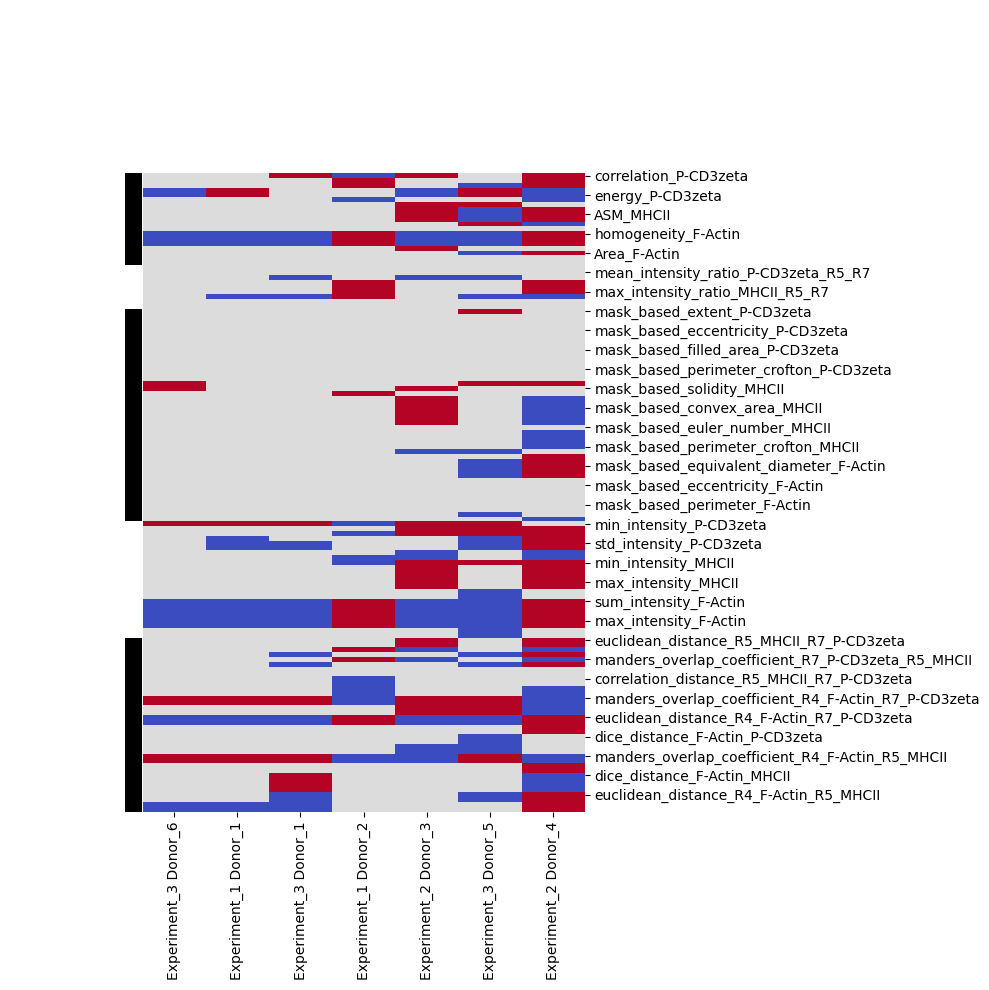

In [25]:
metadata_p_values_copy = metadata_p_values.T.copy()
feature_type_color_map = {
    'colocalization':"black", 
    'intensity statistics':"white", 
    'morphology':"black",
    'synaptic feature':"white", 
    'texture':"black"
}

row_colors = [ feature_type_color_map[f]  for f in features_series.feature_type.tolist()]

cm = sns.clustermap(metadata_p_values_copy,
               cmap="coolwarm",
                    row_colors=row_colors,
               row_cluster=False, 
               col_cluster=False,
               vmin = -1,
               vmax = 1)

cm.cax.set_visible(False)
metadata_p_values_copy.to_csv("Source Data Figure 3h.csv", index=False)
plt.savefig('Figure - clustermap cntrl vs Teplizumab feature heatmap.svg', bbox_inches="tight")


In [26]:
row_index = metadata_p_values_copy.index.str.contains("P-CD3zeta")
# row_index = row_index & (metadata_p_values_copy.abs().sum(1) < -3)

metadata_p_values_copy.loc[row_index,:]


,Experiment_3 Donor_6,Experiment_1 Donor_1,Experiment_3 Donor_1,Experiment_1 Donor_2,Experiment_2 Donor_3,Experiment_3 Donor_5,Experiment_2 Donor_4
correlation_P-CD3zeta,0.0,-0.0,1.0,-1.0,1.0,0.0,1.0
dissimilarity_P-CD3zeta,0.0,0.0,0.0,1.0,-0.0,-0.0,1.0
contrast_P-CD3zeta,-0.0,-0.0,-0.0,1.0,-0.0,-1.0,1.0
ASM_P-CD3zeta,-1.0,1.0,-0.0,-0.0,-1.0,1.0,-1.0
energy_P-CD3zeta,-1.0,1.0,-0.0,-0.0,-1.0,1.0,-1.0
homogeneity_P-CD3zeta,-0.0,-0.0,-0.0,-1.0,0.0,0.0,-1.0
sum_intensity_ratio_P-CD3zeta_R5_R7,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
mean_intensity_ratio_P-CD3zeta_R5_R7,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
max_intensity_ratio_P-CD3zeta_R5_R7,-0.0,-0.0,-1.0,-0.0,-1.0,-1.0,-0.0
mask_based_extent_P-CD3zeta,-0.0,-0.0,0.0,-0.0,0.0,1.0,-0.0


In [27]:
(metadata_p_values_copy.sum(0) > 3)


Experiment_3 Donor_6    False
Experiment_1 Donor_1    False
Experiment_3 Donor_1    False
Experiment_1 Donor_2     True
Experiment_2 Donor_3     True
Experiment_3 Donor_5    False
Experiment_2 Donor_4     True
dtype: bool

In [28]:
metadata_p_values_copy.sum(1) >3


correlation_P-CD3zeta                        False
dissimilarity_P-CD3zeta                      False
contrast_P-CD3zeta                           False
ASM_P-CD3zeta                                False
energy_P-CD3zeta                             False
                                             ...  
correlation_distance_R5_MHCII_R4_F-Actin     False
euclidean_distance_R4_F-Actin_R5_MHCII       False
euclidean_distance_R5_MHCII_R4_F-Actin       False
structural_similarity_R4_F-Actin_R5_MHCII    False
structural_similarity_R5_MHCII_R4_F-Actin    False
Length: 132, dtype: bool

mean_increase: 20.0 std_increase: 15.0 mean_decrease: -23.0 std_decrease: 9.0


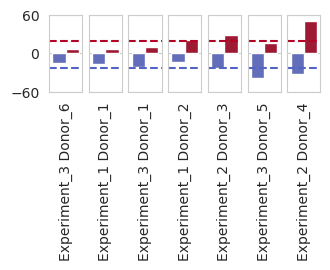

In [29]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols = len(metadata_p_values.index), 
                       nrows = 1,
                       figsize = (0.5*len(metadata_p_values.index) , 1), 
                       sharey = True)


metadata_p_values_aggregated = pd.DataFrame(columns = ["donor", "feature", "direction"])

for donor in metadata_p_values.index:
        indx = metadata_p_values.index == donor
        dummy_increase = {
            "donor": donor,
            "feature": (metadata_p_values.loc[indx,:] > 0.).sum().sum(),
            "direction": "increase"
        }
        dummy_increase = pd.DataFrame(dummy_increase,index=[0])
        metadata_p_values_aggregated = pd.concat([metadata_p_values_aggregated, dummy_increase]).reset_index(drop=True)
        
        dummy_decrease = {
            "donor": donor,
            "feature": (metadata_p_values.loc[indx,:] < 0.).sum().sum()*(-1.),
            "direction": "decrease"
        }
        dummy_decrease = pd.DataFrame(dummy_decrease,index=[0])
        metadata_p_values_aggregated = pd.concat([metadata_p_values_aggregated, dummy_decrease]).reset_index(drop=True)
        
metadata_p_values_aggregated["feature"] = metadata_p_values_aggregated["feature"].astype(float)

indx = metadata_p_values_aggregated["direction"] == "increase" 
mean_increase = metadata_p_values_aggregated.loc[indx, "feature"].mean()
std_increase = metadata_p_values_aggregated.loc[indx, "feature"].std() 

indx = metadata_p_values_aggregated["direction"] == "decrease" 
mean_decrease = metadata_p_values_aggregated.loc[indx, "feature"].mean()
std_decrease = metadata_p_values_aggregated.loc[indx, "feature"].std() 

print("mean_increase:", round(mean_increase,0),
      "std_increase:", round(std_increase,0),
      "mean_decrease:", round(mean_decrease,0),
     "std_decrease:", round(std_decrease,0))

c_lim = metadata_p_values_aggregated["feature"].abs().max() + 2.
c_lim = c_lim + 10 - (c_lim % 5)


for i, donor in enumerate(metadata_p_values.index):
    ax[i].axhline(mean_increase, c = (180/255.,4/255.,38/255.,1.), ls = "--")
    ax[i].axhline(mean_decrease, c = (84/255.,99/255.,199/255.,1.), ls = "--")
        
    indx = metadata_p_values_aggregated.donor == donor

    ax[i] = sns.barplot(data = metadata_p_values_aggregated.loc[indx,:],
                        x = "donor",
                        y = "feature", 
                        hue = "direction",
                        hue_order = ["decrease","increase"],
                        palette = [(84/255.,99/255.,199/255.,1.),(180/255.,4/255.,38/255.,1.)],
                        ax = ax[i])
    ax[i].legend().remove()
    ax[i].set_xticklabels([donor], rotation = "vertical")
    ax[i].set_ylabel("", rotation = "vertical")
    ax[i].set_xlabel("", rotation = "vertical")
    
    ax[i].set_ylim([-1*c_lim, c_lim]) 
    ax[i].set_yticks([-1*c_lim, 0,c_lim])

plt.savefig('Figure - aggregated features cntrl vs Teplizumab feature barplot.svg', bbox_inches="tight")


In [30]:
indx = metadata_p_values_aggregated["direction"] == "increase" 
metadata_p_values_aggregated.loc[indx, :]

,donor,feature,direction
0,Experiment_3 Donor_6,7.0,increase
2,Experiment_1 Donor_1,7.0,increase
4,Experiment_3 Donor_1,10.0,increase
6,Experiment_1 Donor_2,20.0,increase
8,Experiment_2 Donor_3,28.0,increase
10,Experiment_3 Donor_5,16.0,increase
12,Experiment_2 Donor_4,50.0,increase


In [31]:
indx = metadata_p_values_aggregated["direction"] == "decrease" 
metadata_p_values_aggregated.loc[indx, :]

,donor,feature,direction
1,Experiment_3 Donor_6,-15.0,decrease
3,Experiment_1 Donor_1,-17.0,decrease
5,Experiment_3 Donor_1,-21.0,decrease
7,Experiment_1 Donor_2,-14.0,decrease
9,Experiment_2 Donor_3,-23.0,decrease
11,Experiment_3 Donor_5,-39.0,decrease
13,Experiment_2 Donor_4,-32.0,decrease


In [32]:
## Overal postiive and negative 

print("possible changes: ", metadata_p_values.shape[0] * metadata_p_values.shape[1])
features_series.sum()


possible changes:  924


feature                       correlation_P-CD3zetadissimilarity_P-CD3zetaco...
feature_type                  texturetexturetexturetexturetexturetexturetext...
channel_1                     4_P-CD3zeta4_P-CD3zeta4_P-CD3zeta4_P-CD3zeta4_...
channel_2                     4_P-CD3zeta4_P-CD3zeta4_P-CD3zeta4_P-CD3zeta4_...
num_pos_significant_donors                                                138.0
num_neg_significant_donors                                               -161.0
num_significant_donors                                                    299.0
significant_feature                                                       194.0
significant_feature_3_exp                                                    28
significant_feature_2_exp                                                    65
significant_feature_1_exp                                                   101
dtype: object

### Features which are at least for five donor increased or decreased plus their category

In [33]:
indx = features_series.num_pos_significant_donors >= 5

features_series.loc[indx,:].sort_values(["num_significant_donors",
                            "significant_feature_3_exp"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors
108,manders_overlap_coefficient_R4_F-Actin_R7_P-CD...,colocalization,7.0,5.0,-2.0
109,manders_overlap_coefficient_R7_P-CD3zeta_R4_F-...,colocalization,7.0,5.0,-2.0
72,min_intensity_P-CD3zeta,intensity statistics,6.0,5.0,-1.0


In [34]:
indx = features_series.num_neg_significant_donors <= -5

features_series.loc[indx,:].sort_values(["num_significant_donors",
                            "significant_feature_3_exp"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors
12,homogeneity_F-Actin,texture,7.0,2.0,-5.0
13,ASM_F-Actin,texture,7.0,2.0,-5.0
14,energy_F-Actin,texture,7.0,2.0,-5.0
88,sum_intensity_F-Actin,intensity statistics,7.0,2.0,-5.0
89,mean_intensity_F-Actin,intensity statistics,7.0,2.0,-5.0
90,std_intensity_F-Actin,intensity statistics,7.0,2.0,-5.0
91,min_intensity_F-Actin,intensity statistics,7.0,2.0,-5.0
92,max_intensity_F-Actin,intensity statistics,7.0,2.0,-5.0
93,shannon_entropy_F-Actin,intensity statistics,7.0,2.0,-5.0
112,euclidean_distance_R4_F-Actin_R7_P-CD3zeta,colocalization,7.0,2.0,-5.0


In [35]:
indx = features_series.feature_type == "texture"
print("texture features",indx.sum())
indx = indx & (features_series.num_neg_significant_donors <= -5)
print("texture features for minimum 5 donors",indx.sum())
features_series.loc[indx,:].sort_values(["num_significant_donors",
                            "significant_feature_3_exp",
                            "significant_feature_2_exp"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


texture features 19
texture features for minimum 5 donors 3


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors
12,homogeneity_F-Actin,texture,7.0,2.0,-5.0
13,ASM_F-Actin,texture,7.0,2.0,-5.0
14,energy_F-Actin,texture,7.0,2.0,-5.0


In [36]:
indx = features_series.feature_type == "synaptic feature"
print("synaptic feature features",indx.sum())
indx = indx & (features_series.num_neg_significant_donors <= -5)
print("synaptic feature features for minimum 5 donors",indx.sum())
features_series.loc[indx,:].sort_values(["num_significant_donors",
                            "significant_feature_3_exp"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


synaptic feature features 9
synaptic feature features for minimum 5 donors 0


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors


In [37]:
indx = features_series.feature_type == "morphology"
print("morphology features",indx.sum())
indx = indx & (features_series.num_neg_significant_donors <= -5)
print("morphology features for minimum 5 donors",indx.sum())
features_series.loc[indx,:].sort_values(["num_significant_donors",
                            "significant_feature_3_exp"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


morphology features 44
morphology features for minimum 5 donors 0


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors


In [38]:
indx = features_series.feature_type == "intensity statistics"
print("intensity statistics features",indx.sum())
indx = indx & (features_series.num_neg_significant_donors <= -5)
print("intensity statistics features for minimum 5 donors",indx.sum())
features_series.loc[indx,:].sort_values(["num_significant_donors",
                            "significant_feature_3_exp"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


intensity statistics features 24
intensity statistics features for minimum 5 donors 6


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors
88,sum_intensity_F-Actin,intensity statistics,7.0,2.0,-5.0
89,mean_intensity_F-Actin,intensity statistics,7.0,2.0,-5.0
90,std_intensity_F-Actin,intensity statistics,7.0,2.0,-5.0
91,min_intensity_F-Actin,intensity statistics,7.0,2.0,-5.0
92,max_intensity_F-Actin,intensity statistics,7.0,2.0,-5.0
93,shannon_entropy_F-Actin,intensity statistics,7.0,2.0,-5.0


In [39]:
indx = features_series.feature_type == "colocalization"
print("colocalization features",indx.sum())
indx = indx & (features_series.num_neg_significant_donors <= -5)
print("colocalization features for minimum 5 donors",indx.sum())
features_series.loc[indx,:].sort_values(["num_significant_donors",
                            "significant_feature_3_exp"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


colocalization features 36
colocalization features for minimum 5 donors 2


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors
112,euclidean_distance_R4_F-Actin_R7_P-CD3zeta,colocalization,7.0,2.0,-5.0
113,euclidean_distance_R7_P-CD3zeta_R4_F-Actin,colocalization,7.0,2.0,-5.0


In [40]:
indx = features_series.feature_type == "colocalization"
print("colocalization features",indx.sum())
indx = indx & (features_series.num_pos_significant_donors >= 5)
print("colocalization features for minimum 5 donors",indx.sum())
features_series.loc[indx,:].sort_values(["num_significant_donors",
                            "significant_feature_3_exp"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


colocalization features 36
colocalization features for minimum 5 donors 2


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors
108,manders_overlap_coefficient_R4_F-Actin_R7_P-CD...,colocalization,7.0,5.0,-2.0
109,manders_overlap_coefficient_R7_P-CD3zeta_R4_F-...,colocalization,7.0,5.0,-2.0


In [41]:
indx = features_series.feature_type == "colocalization"
features_series.loc[indx,:].sort_values(["num_significant_donors",
                            "significant_feature_3_exp"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors
108,manders_overlap_coefficient_R4_F-Actin_R7_P-CD...,colocalization,7.0,5.0,-2.0
109,manders_overlap_coefficient_R7_P-CD3zeta_R4_F-...,colocalization,7.0,5.0,-2.0
112,euclidean_distance_R4_F-Actin_R7_P-CD3zeta,colocalization,7.0,2.0,-5.0
113,euclidean_distance_R7_P-CD3zeta_R4_F-Actin,colocalization,7.0,2.0,-5.0
120,manders_overlap_coefficient_R4_F-Actin_R5_MHCII,colocalization,7.0,4.0,-3.0
121,manders_overlap_coefficient_R5_MHCII_R4_F-Actin,colocalization,7.0,4.0,-3.0
130,structural_similarity_R4_F-Actin_R5_MHCII,colocalization,4.0,1.0,-3.0
131,structural_similarity_R5_MHCII_R4_F-Actin,colocalization,4.0,1.0,-3.0
98,manders_overlap_coefficient_R5_MHCII_R7_P-CD3zeta,colocalization,3.0,1.0,-2.0
99,structural_similarity_R5_MHCII_R7_P-CD3zeta,colocalization,3.0,1.0,-2.0


In [42]:
features_series


,feature,feature_type,channel_1,channel_2,num_pos_significant_donors,num_neg_significant_donors,num_significant_donors,significant_feature,significant_feature_3_exp,significant_feature_2_exp,significant_feature_1_exp
0,correlation_P-CD3zeta,texture,4_P-CD3zeta,,3.0,-1.0,4.0,3.0,True,True,True
1,dissimilarity_P-CD3zeta,texture,4_P-CD3zeta,,2.0,0.0,2.0,2.0,False,True,True
2,contrast_P-CD3zeta,texture,4_P-CD3zeta,,2.0,-1.0,3.0,3.0,True,True,True
3,ASM_P-CD3zeta,texture,4_P-CD3zeta,,2.0,-3.0,5.0,3.0,True,True,True
4,energy_P-CD3zeta,texture,4_P-CD3zeta,,2.0,-3.0,5.0,3.0,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
127,correlation_distance_R5_MHCII_R4_F-Actin,colocalization,1_F-Actin,2_MHCII,1.0,-1.0,2.0,2.0,False,True,True
128,euclidean_distance_R4_F-Actin_R5_MHCII,colocalization,1_F-Actin,2_MHCII,1.0,-2.0,3.0,2.0,False,True,True
129,euclidean_distance_R5_MHCII_R4_F-Actin,colocalization,1_F-Actin,2_MHCII,1.0,-2.0,3.0,2.0,False,True,True
130,structural_similarity_R4_F-Actin_R5_MHCII,colocalization,1_F-Actin,2_MHCII,1.0,-3.0,4.0,3.0,True,True,True


Now lets save the features

In [43]:
# indx = features_series["feature_type"] == "colocalization"
# features_series.loc[indx,:].groupby(["feature_type"]).mean().round(2) 


In [44]:
np.where(metadata_p_values.sum(0).sort_values( ascending=True).index.isin(['mean_intensity_P-CD3zeta','mean_intensity_F-Actin']))


(array([ 11, 115]),)

In [45]:
metadata_p_values.loc[key_order,['contrast_P-CD3zeta',
                                 'manders_overlap_coefficient_R4_F-Actin_R7_P-CD3zeta',
                                 'mean_intensity_P-CD3zeta',
                                 'max_intensity_ratio_P-CD3zeta_R5_R7',
                                 'mean_intensity_ratio_P-CD3zeta_R5_R7',
                                 'sum_intensity_ratio_P-CD3zeta_R5_R7',
                                 'mean_intensity_F-Actin']]


,contrast_P-CD3zeta,manders_overlap_coefficient_R4_F-Actin_R7_P-CD3zeta,mean_intensity_P-CD3zeta,max_intensity_ratio_P-CD3zeta_R5_R7,mean_intensity_ratio_P-CD3zeta_R5_R7,sum_intensity_ratio_P-CD3zeta_R5_R7,mean_intensity_F-Actin
Experiment_3 Donor_6,-0.0,1.0,0.0,-0.0,-0.0,-0.0,-1.0
Experiment_1 Donor_1,-0.0,1.0,-0.0,-0.0,0.0,0.0,-1.0
Experiment_3 Donor_1,-0.0,1.0,0.0,-1.0,-0.0,-0.0,-1.0
Experiment_1 Donor_2,1.0,-1.0,-1.0,-0.0,0.0,0.0,1.0
Experiment_2 Donor_3,-0.0,1.0,1.0,-1.0,-0.0,-0.0,-1.0
Experiment_3 Donor_5,-1.0,1.0,1.0,-1.0,0.0,0.0,-1.0
Experiment_2 Donor_4,1.0,-1.0,1.0,-0.0,-0.0,-0.0,1.0


In [46]:
metadata_p_values.shape

(7, 132)

In [47]:
np.where(metadata_p_values.columns.isin(['contrast_P-CD3zeta',
                                 'manders_overlap_coefficient_R4_F-Actin_R7_P-CD3zeta',
                                 'mean_intensity_P-CD3zeta',
                                 'max_intensity_ratio_P-CD3zeta_R5_R7',
                                 'mean_intensity_ratio_P-CD3zeta_R5_R7',
                                 'sum_intensity_ratio_P-CD3zeta_R5_R7',
                                 'mean_intensity_F-Actin']))


(array([  2,  19,  20,  21,  74,  89, 108]),)

In [48]:
pd.options.display.float_format = '{:.1e}'.format
p_values_float.loc[key_order,['contrast_P-CD3zeta',
                                 'manders_overlap_coefficient_R4_F-Actin_R7_P-CD3zeta',
                                 'mean_intensity_P-CD3zeta',
                                 'max_intensity_ratio_P-CD3zeta_R5_R7',
                                 'mean_intensity_ratio_P-CD3zeta_R5_R7',
                                 'sum_intensity_ratio_P-CD3zeta_R5_R7',
                                 'mean_intensity_F-Actin']]

,contrast_P-CD3zeta,manders_overlap_coefficient_R4_F-Actin_R7_P-CD3zeta,mean_intensity_P-CD3zeta,max_intensity_ratio_P-CD3zeta_R5_R7,mean_intensity_ratio_P-CD3zeta_R5_R7,sum_intensity_ratio_P-CD3zeta_R5_R7,mean_intensity_F-Actin
Experiment_3 Donor_6,6.2e-02,1.3e-17,9.4e-01,9.0e-02,1.3e-01,1.3e-01,4.3e-24
Experiment_1 Donor_1,5.1e-02,7.7e-16,9.2e-02,1.4e-01,7.6e-01,7.6e-01,8.7e-15
Experiment_3 Donor_1,2.1e-01,1.9e-10,3.7e-01,7.5e-06,1.1e-01,1.1e-01,4.4e-15
Experiment_1 Donor_2,1.7e-02,2.2e-16,3.5e-05,4.1e-01,3.2e-01,3.2e-01,4.3e-22
Experiment_2 Donor_3,2.1e-01,1.0e-06,5.6e-35,1.8e-08,9.4e-01,9.4e-01,3.0e-12
Experiment_3 Donor_5,1.3e-16,1.8e-38,2.0e-03,1.8e-05,9.2e-01,9.2e-01,1.4e-52
Experiment_2 Donor_4,7.0e-28,6.8e-18,7.9e-33,1.5e-01,9.9e-01,9.9e-01,5.2e-13


In [49]:
p_values_float.loc[key_order,['contrast_P-CD3zeta',
                                 'manders_overlap_coefficient_R4_F-Actin_R7_P-CD3zeta',
                                 'mean_intensity_P-CD3zeta',
                                 'max_intensity_ratio_P-CD3zeta_R5_R7',
                                 'mean_intensity_ratio_P-CD3zeta_R5_R7',
                                 'sum_intensity_ratio_P-CD3zeta_R5_R7',
                                 'mean_intensity_F-Actin']].round(3)

,contrast_P-CD3zeta,manders_overlap_coefficient_R4_F-Actin_R7_P-CD3zeta,mean_intensity_P-CD3zeta,max_intensity_ratio_P-CD3zeta_R5_R7,mean_intensity_ratio_P-CD3zeta_R5_R7,sum_intensity_ratio_P-CD3zeta_R5_R7,mean_intensity_F-Actin
Experiment_3 Donor_6,6.2e-02,0.0e+00,9.4e-01,9.0e-02,1.4e-01,1.4e-01,0.0e+00
Experiment_1 Donor_1,5.1e-02,0.0e+00,9.2e-02,1.4e-01,7.6e-01,7.6e-01,0.0e+00
Experiment_3 Donor_1,2.1e-01,0.0e+00,3.7e-01,0.0e+00,1.1e-01,1.1e-01,0.0e+00
Experiment_1 Donor_2,1.7e-02,0.0e+00,0.0e+00,4.1e-01,3.2e-01,3.2e-01,0.0e+00
Experiment_2 Donor_3,2.1e-01,0.0e+00,0.0e+00,0.0e+00,9.4e-01,9.4e-01,0.0e+00
Experiment_3 Donor_5,0.0e+00,0.0e+00,2.0e-03,0.0e+00,9.2e-01,9.2e-01,0.0e+00
Experiment_2 Donor_4,0.0e+00,0.0e+00,0.0e+00,1.5e-01,9.9e-01,9.9e-01,0.0e+00


In [50]:
p_values_float.loc[key_order,['contrast_P-CD3zeta',
                                 'manders_overlap_coefficient_R4_F-Actin_R7_P-CD3zeta',
                                 'mean_intensity_P-CD3zeta',
                                 'max_intensity_ratio_P-CD3zeta_R5_R7',
                                 'mean_intensity_ratio_P-CD3zeta_R5_R7',
                                 'sum_intensity_ratio_P-CD3zeta_R5_R7',
                                 'mean_intensity_F-Actin']]

,contrast_P-CD3zeta,manders_overlap_coefficient_R4_F-Actin_R7_P-CD3zeta,mean_intensity_P-CD3zeta,max_intensity_ratio_P-CD3zeta_R5_R7,mean_intensity_ratio_P-CD3zeta_R5_R7,sum_intensity_ratio_P-CD3zeta_R5_R7,mean_intensity_F-Actin
Experiment_3 Donor_6,6.2e-02,1.3e-17,9.4e-01,9.0e-02,1.3e-01,1.3e-01,4.3e-24
Experiment_1 Donor_1,5.1e-02,7.7e-16,9.2e-02,1.4e-01,7.6e-01,7.6e-01,8.7e-15
Experiment_3 Donor_1,2.1e-01,1.9e-10,3.7e-01,7.5e-06,1.1e-01,1.1e-01,4.4e-15
Experiment_1 Donor_2,1.7e-02,2.2e-16,3.5e-05,4.1e-01,3.2e-01,3.2e-01,4.3e-22
Experiment_2 Donor_3,2.1e-01,1.0e-06,5.6e-35,1.8e-08,9.4e-01,9.4e-01,3.0e-12
Experiment_3 Donor_5,1.3e-16,1.8e-38,2.0e-03,1.8e-05,9.2e-01,9.2e-01,1.4e-52
Experiment_2 Donor_4,7.0e-28,6.8e-18,7.9e-33,1.5e-01,9.9e-01,9.9e-01,5.2e-13


In [51]:
features_series_to_be_saved = features_series.copy()
features_series_to_be_saved.index = features_series_to_be_saved["feature"]
indx = features_series_to_be_saved["num_pos_significant_donors"] > 3
indx = indx | (features_series_to_be_saved["num_neg_significant_donors"] < -3)
cols = ["feature_type"]
features_series_to_be_saved = pd.merge(features_series_to_be_saved.sort_values(["num_significant_donors","feature_type"], ascending=False).loc[indx,cols], 
         metadata_p_values.T, 
         left_index = True, 
         right_index = True).round(0)

new_cols = dict()
for col in metadata_p_values.index.values:
    new_cols[col] = col.replace("xperiment_","").replace("onor_","") 
features_series_to_be_saved = features_series_to_be_saved.rename(columns = new_cols )

features_series_to_be_saved.sort_values(["feature_type"], ascending=False).to_csv("Teplizumab_comparison_top_features.csv")


In [52]:

indx = (metadata["prediction"].isin([  "Synapses_with_signaling"])) # "Synapses_without_signaling",
indx = indx&(metadata["outlier"].isin([0]))
indx = indx&(metadata["condition"].isin(["Isotype", "Teplizumab"]))
cols_features = ['contrast_P-CD3zeta',
                                 'manders_overlap_coefficient_R4_F-Actin_R7_P-CD3zeta',
                                 'mean_intensity_P-CD3zeta',
                                 'max_intensity_ratio_P-CD3zeta_R5_R7',
                                 'mean_intensity_F-Actin']
cols_metadata = [ "condition", "key", "object_number"]

df_visualization =  pd.concat([df_features.loc[indx,cols_features], metadata.loc[indx,cols_metadata]], axis=1 ).copy()

from sklearn.preprocessing import RobustScaler
for k in df_visualization.key.unique():
    indx = df_visualization.key == k
    for col in cols_features:
        min_ = df_visualization.loc[indx,col].quantile(0.05)
        max_ = df_visualization.loc[indx,col].quantile(0.95)
        df_visualization.loc[indx,col] = (df_visualization.loc[indx,col] -  min_)/ (max_ - min_)

for col in cols_features:
    df_visualization.loc[df_visualization.loc[:,col] >= 1.,col] = 1.
    df_visualization.loc[df_visualization.loc[:,col] <= 0.,col] = 0.


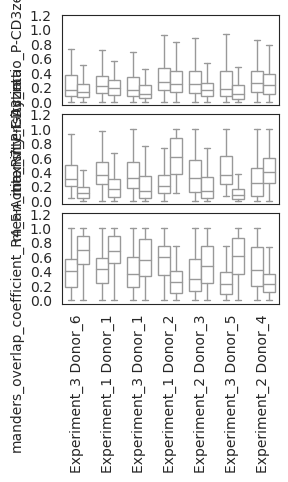

In [53]:
sns.set_style("white")

fig, ax  = plt.subplots(3,1,figsize = (0.4*7,1.25*3),sharex = True)

from itertools import cycle
hatches = cycle(['', '//////'])





col = 'max_intensity_ratio_P-CD3zeta_R5_R7'
ax[0] = sns.boxplot(data=df_visualization , 
                    x = "key", 
                    order = key_order,
                    dodge=True,
                    linewidth = 1.,
                    y= col, 
                    showfliers = False,
                    hue_order =["Isotype", "Teplizumab"],
                    palette =["white", "white"],
                    hue = "condition",
                  ax = ax[0])  
ax[0].legend().remove() 
ax[0].set_xlabel("")   
ax[0].set_yticks([0.,0.2,0.4,0.6,0.8,1.0,1.2])  

col = 'mean_intensity_F-Actin'
ax[1] = sns.boxplot(data=df_visualization , 
                    x = "key", 
                    order = key_order,
                    dodge=True,
                    linewidth = 1.,
                    y= col, 
                    showfliers = False,
                    hue_order =["Isotype", "Teplizumab"],
                    palette =["white", "white"],
                    hue = "condition",
                  ax = ax[1])  


ax[1].legend().remove()
ax[1].set_xlabel("")   
ax[1].set_yticks([0.,0.2,0.4,0.6,0.8,1.0,1.2])  

col = 'manders_overlap_coefficient_R4_F-Actin_R7_P-CD3zeta'
ax[2] = sns.boxplot(data=df_visualization , 
                    x = "key", 
                    order = key_order,
                    dodge=True,
                    linewidth = 1.,
                    y= col, 
                    showfliers = False,
                    hue_order =["Isotype", "Teplizumab"],
                    palette =["white", "white"],
                    hue = "condition",
                  ax = ax[2])  


ax[2].legend().remove()
ax[2].set_xlabel("")   
ax[2].set_yticks([0.,0.2,0.4,0.6,0.8,1.0,1.2])  


ax[2].set_xticklabels(key_order, rotation = "vertical")

for i in range(3):
    for _, patch in enumerate(ax[i].artists):
    # Boxes from left to right
        #hatch = next(hatches)
        patch.set_hatch("//")
        patch.set_edgecolor('black')

fig.subplots_adjust(hspace=0.1, wspace= 0.1) 
plt.savefig('Figure - Boxplot cntrl vs Teplizumab synapses with signaling.svg', bbox_inches="tight")


In [54]:
df_visualization.to_csv("Source Data Figure 3i-k.csv", index=False)

[492.0, 8.0, 40.0, 42.0, 52.0, 40.0] [1159.0, 583.0, 2213.6699999999964, 1083.9549999999972, 654.0, 85.0]


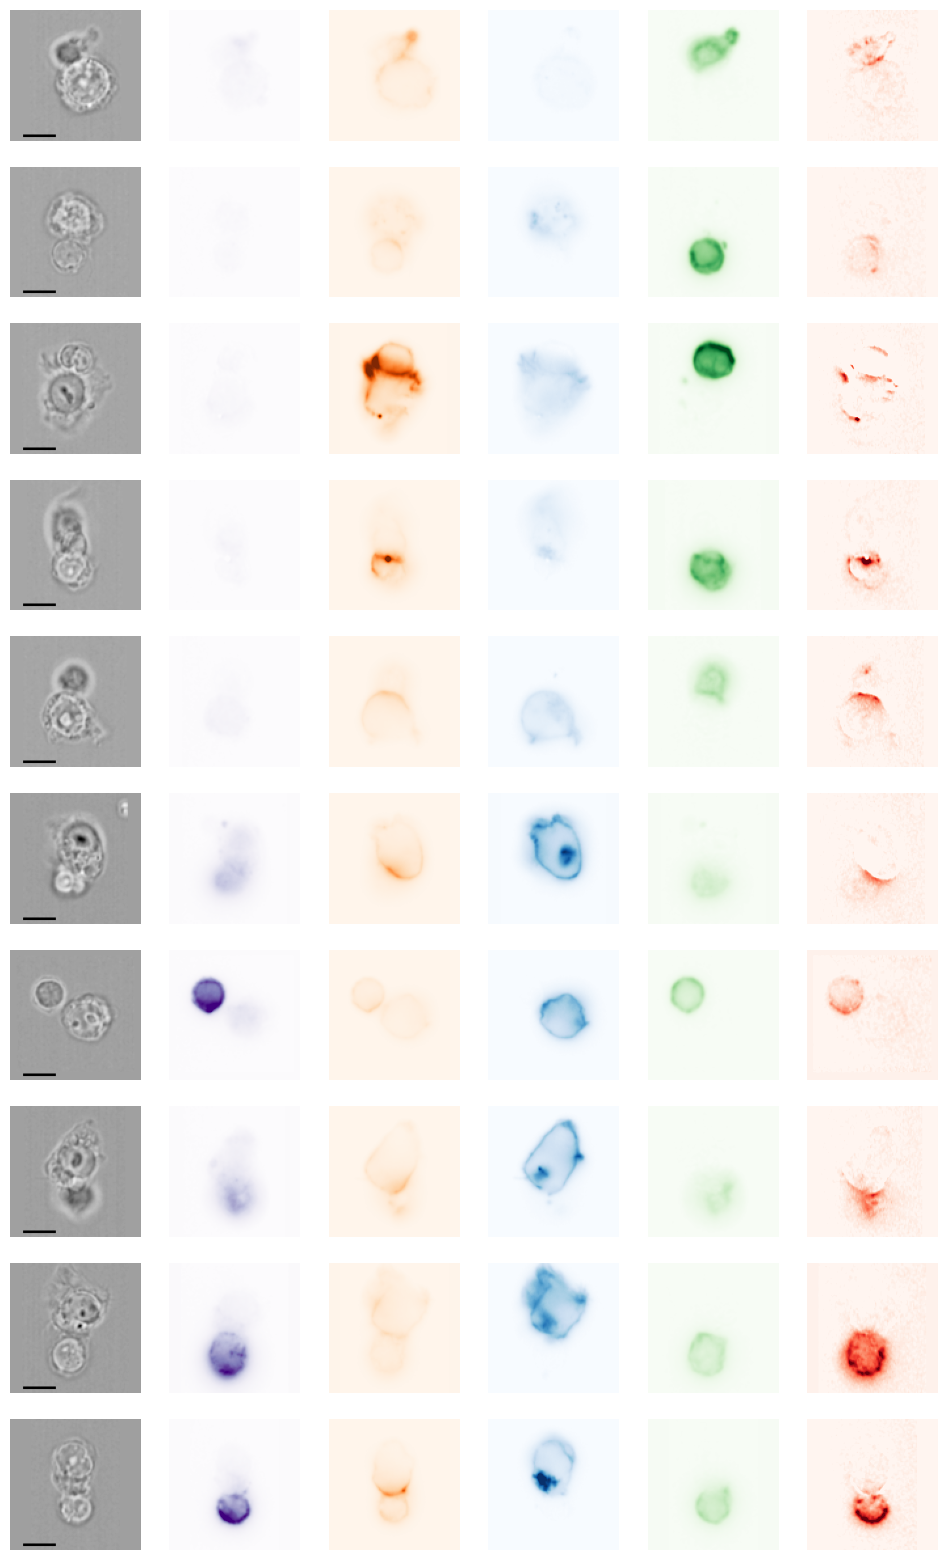

In [55]:
k = 5 
image_size = 100
channels_to_be_plotted = [0,1,3,4,5,6]
channel_colors = ["Greys","Purples","Oranges" ,"Blues", "Greens","Reds"]

# indx1 = metadata["donor"] == "Donor_3"
# indx1 = indx1&(metadata["experiment"] == "Experiment_2")
# indx1 = indx1&(metadata["prediction"].isin(["Synapses_with_signaling"])) # Synapses
# indx1 = indx1&(metadata["outlier"].isin([0]))
# indx1 = indx1&(metadata["condition"].isin(["Isotype" ]))
# indx1 = indx1[indx1].sample(k).index.tolist()


# indx2 = metadata["donor"] == "Donor_3"
# indx2 = indx2&(metadata["experiment"] == "Experiment_2")
# indx2 = indx2&(metadata["prediction"].isin(["Synapses_with_signaling"])) 
# indx2 = indx2&(metadata["outlier"].isin([0])) 
# indx2 = indx2&(metadata["condition"].isin(["Teplizumab" ]))
# indx2 = indx2[indx2].sample(k).index.tolist()

indx1 = [209810, 212063 , 214847, 215025,220666]
indx1 = sorted(indx1)
indx2 = [242093,235601, 236558,236334,238387 ]  # 
indx2 = sorted(indx2)



files = metadata.loc[indx1+indx2,:].sort_values("object_number")["file"].tolist()

nrows = 2*k
ncols = len(channels_to_be_plotted)

fix,ax = plt.subplots(nrows, ncols, figsize = ( ncols*2, nrows*2 ))
    
vmin = [4095.]*ncols
vmax = [0.]*ncols

for i in range(nrows):
    h5_file_ = h5py.File(files[i].replace("/pstore/data/DS4/", "/projects/site/pred/data_science/year/2022/immunological_synapse/"), "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for j, ch in enumerate(channels_to_be_plotted):
        if j>0:
            vmin[j] = min(vmin[j], np.quantile(image[:,:,ch], 0.60)  )
            vmax[j] = max(vmax[j], np.quantile(image[:,:,ch], 0.995)  )
        else:
            vmin[j] = min(vmin[j], np.quantile(image[:,:,ch], 0.0)  )
            vmax[j] = max(vmax[j], np.quantile(image[:,:,ch], 1.0)  )

        
print(vmin,vmax)
for i in range(nrows):
    h5_file_ = h5py.File(files[i].replace("/pstore/data/DS4/", "/projects/site/pred/data_science/year/2022/immunological_synapse/"), "r")
    image = h5_file_.get("image")[()]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    for j, ch in enumerate(channels_to_be_plotted):
            image_dummy = crop(image[:,:,ch], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values=np.median(image_dummy) )
            if j == 0:
                image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] = vmax[j]
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].axis('off')
    h5_file_.close()


plt.savefig('Figure - sample images Teplizumab vs Isotyp synapses.svg', bbox_inches="tight")


In [56]:

indx = metadata.file.isin(files)
object_numbers =  metadata.loc[indx,"object_number"]
metadata.loc[indx,:].sort_values("object_number")


,file,experiment,donor,condition,object_number,set,label,prediction,entropy,key,outlier,cluster
212063,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_2,Donor_3,Isotype,134682,unlabeled,-1,Synapses_with_signaling,4.5e-02,Experiment_2 Donor_3,0,1
220666,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_2,Donor_3,Isotype,155963,unlabeled,-1,Synapses_with_signaling,1.9e-01,Experiment_2 Donor_3,0,1
209810,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_2,Donor_3,Isotype,158621,unlabeled,-1,Synapses_with_signaling,3.0e-01,Experiment_2 Donor_3,0,1
215025,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_2,Donor_3,Isotype,168309,unlabeled,-1,Synapses_with_signaling,6.5e-03,Experiment_2 Donor_3,0,1
214847,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_2,Donor_3,Isotype,175271,unlabeled,-1,Synapses_with_signaling,7.5e-03,Experiment_2 Donor_3,0,1
236558,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_2,Donor_3,Teplizumab,520181,unlabeled,-1,Synapses_with_signaling,1.2e-01,Experiment_2 Donor_3,0,1
235601,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_2,Donor_3,Teplizumab,529034,unlabeled,-1,Synapses_with_signaling,6.8e-01,Experiment_2 Donor_3,0,1
242093,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_2,Donor_3,Teplizumab,529555,unlabeled,-1,Synapses_with_signaling,4.3e-01,Experiment_2 Donor_3,0,1
238387,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_2,Donor_3,Teplizumab,545280,unlabeled,-1,Synapses_with_signaling,6.9e-01,Experiment_2 Donor_3,0,1
236334,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_2,Donor_3,Teplizumab,548915,unlabeled,-1,Synapses_with_signaling,1.8e-01,Experiment_2 Donor_3,0,1


In [57]:
indx = df_visualization.key == "Experiment_2 Donor_3"
indx = indx & (df_visualization.object_number.isin(object_numbers) )
df_visualization.loc[indx,:].sort_values("object_number").round(2)


,contrast_P-CD3zeta,manders_overlap_coefficient_R4_F-Actin_R7_P-CD3zeta,mean_intensity_P-CD3zeta,max_intensity_ratio_P-CD3zeta_R5_R7,mean_intensity_F-Actin,condition,key,object_number
212063,1.7e-01,2.5e-01,2.6e-01,8.0e-02,5.3e-01,Isotype,Experiment_2 Donor_3,134682
220666,0.0e+00,7.0e-01,2.9e-01,1.5e-01,1.1e-01,Isotype,Experiment_2 Donor_3,155963
209810,5.7e-01,5.0e-02,0.0e+00,4.9e-01,9.7e-01,Isotype,Experiment_2 Donor_3,158621
215025,1.0e-02,1.0e-01,4.0e-01,4.8e-01,4.1e-01,Isotype,Experiment_2 Donor_3,168309
214847,1.5e-01,6.3e-01,2.6e-01,1.2e-01,1.0e-01,Isotype,Experiment_2 Donor_3,175271
236558,2.4e-01,3.3e-01,2.4e-01,1.3e-01,3.1e-01,Teplizumab,Experiment_2 Donor_3,520181
235601,9.0e-02,7.7e-01,4.2e-01,1.7e-01,5.0e-02,Teplizumab,Experiment_2 Donor_3,529034
242093,1.1e-01,5.0e-01,3.9e-01,3.0e-02,1.2e-01,Teplizumab,Experiment_2 Donor_3,529555
238387,3.0e-01,4.7e-01,1.0e+00,5.0e-02,1.0e-01,Teplizumab,Experiment_2 Donor_3,545280
236334,4.9e-01,1.9e-01,7.2e-01,3.0e-02,3.7e-01,Teplizumab,Experiment_2 Donor_3,548915


# TCB vs Cntrl-TCB synapses

In [58]:
from scipy import stats
from statsmodels.stats.multitest import multipletests

key_order = [ 
             'Experiment_3 Donor_1',
             'Experiment_3 Donor_5',
             'Experiment_4 Donor_2',
             'Experiment_4 Donor_7',
             'Experiment_4 Donor_8',
             'Experiment_4 Donor_9']

most_important_features =  df_features.columns[classification_indx]  
metadata_p_values = pd.DataFrame(columns= most_important_features)
metadata_feature_direction = pd.DataFrame(columns= most_important_features)

for k in key_order: 
    indx = metadata["key"] == k
    indx = indx&(metadata["prediction"].isin([ "Synapses_with_signaling"])) 
    indx = indx&(metadata["outlier"].isin([0])) # Synapses
    indx_dig_tcb = indx&(metadata["condition"] == "DIG-TCB")
    indx_tcb = indx&(metadata["condition"] == 'CD19-TCB')

    if indx_dig_tcb.sum()*indx_tcb.sum():
        print(k)
        print("indx_dig_tcb", indx_dig_tcb.sum())
        print("indx_tcb", indx_tcb.sum())
        new_p_row = dict()
        new_feature_direction = dict()
        for col in most_important_features:
            xx = df_features.loc[indx_dig_tcb , col].tolist()
            yy = df_features.loc[indx_tcb , col].tolist()
            
            try:
                new_p_row[col] = stats.mannwhitneyu(xx, yy).pvalue
            except ValueError:
                new_p_row[col] = 1.
                
            new_feature_direction[col] = np.sign(np.median(yy) - np.median(xx))
            
        new_p_row = pd.DataFrame(new_p_row, index = [0])       
        new_feature_direction = pd.DataFrame(new_feature_direction, index = [0])       
        metadata_p_values = pd.concat([metadata_p_values, new_p_row]).reset_index(drop=True)
        metadata_feature_direction = pd.concat([metadata_feature_direction, new_feature_direction]).reset_index(drop=True)


Experiment_3 Donor_1
indx_dig_tcb 77
indx_tcb 666
Experiment_3 Donor_5
indx_dig_tcb 86
indx_tcb 660
Experiment_4 Donor_2
indx_dig_tcb 265
indx_tcb 729
Experiment_4 Donor_7
indx_dig_tcb 96
indx_tcb 822
Experiment_4 Donor_8
indx_dig_tcb 194
indx_tcb 753
Experiment_4 Donor_9
indx_dig_tcb 169
indx_tcb 746


In [59]:
metadata_p_values.index = key_order
metadata_feature_direction.index = key_order


In [60]:
metadata_p_values = metadata_p_values.dropna()

metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("Antibody")]
metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("Live-Dead")]
metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("BF")]
metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("_R1")]
metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("_R2")]
metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("_R8")]
metadata_p_values = metadata_p_values.loc[:,~metadata_p_values.columns.str.contains("moments")]

metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("Antibody")]
metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("Live-Dead")]
metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("BF")]
metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("_R1")]
metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("_R2")]
metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("_R8")]
metadata_feature_direction = metadata_feature_direction.loc[:,~metadata_feature_direction.columns.str.contains("moments")]


In [61]:
print( "from original",
      classification_indx.sum(),
      "feaures, we used",
      metadata_p_values.shape[1])


from original 235 feaures, we used 198


In [62]:
p_values = metadata_p_values.iloc[:,:]
p_values = p_values.to_numpy().reshape(-1).tolist()
#print(multipletests(p_values, method='fdr_bh'))

p_values_float = multipletests(p_values,alpha=0.05 ,method='fdr_bh')[1].reshape( metadata_p_values.shape[0],metadata_p_values.shape[1])

p_values__ = multipletests(p_values,alpha=0.05 ,method='fdr_bh')[0].reshape( metadata_p_values.shape[0],metadata_p_values.shape[1])
metadata_p_values.iloc[:,:] = p_values__

p_values_float = pd.DataFrame(p_values_float, columns=metadata_p_values.columns, index = metadata_p_values.index)


In [63]:
metadata_p_values = metadata_p_values*metadata_feature_direction


In [64]:
p_values = np.array(p_values).reshape( metadata_p_values.shape[0],metadata_p_values.shape[1])


In [65]:
for i in range(len(key_order)):
    indx = (metadata_p_values.abs().sum(0) == len(key_order) - i)
    print("list of features which were significant for", len(key_order) - i, "donor\n\n",
      metadata_p_values.sum(0)[indx].sort_values(ascending = False).index,
         "\n--------------------------------------------------------------\n")


list of features which were significant for 6 donor

 Index(['mean_intensity_P-CD3zeta', 'max_intensity_P-CD3zeta',
       'std_intensity_P-CD3zeta', 'shannon_entropy_P-CD3zeta',
       'mask_based_solidity_MHCII', 'correlation_distance_R4_F-Actin_R5_MHCII',
       'correlation_distance_R5_MHCII_R4_F-Actin'],
      dtype='object') 
--------------------------------------------------------------

list of features which were significant for 5 donor

 Index(['homogeneity_P-CD3zeta', 'skew_intensity_P-CD3zeta',
       'sum_intensity_ratio_MHCII_R5_R7', 'mean_intensity_ratio_MHCII_R5_R7',
       'max_intensity_ratio_MHCII_R5_R7', 'dissimilarity_P-CD3zeta',
       'dice_distance_MHCII_CD3', 'jaccard_distance_MHCII_CD3',
       'dice_distance_MHCII_P-CD3zeta', 'jaccard_distance_MHCII_P-CD3zeta',
       'correlation_distance_R5_MHCII_R6_CD3',
       'correlation_distance_R5_MHCII_R7_P-CD3zeta',
       'correlation_distance_R6_CD3_R5_MHCII',
       'correlation_distance_R6_CD3_R7_P-CD3zeta',
   

In [66]:
metadata_p_values.shape


(6, 198)

In [67]:
features_series = check_feature_type(metadata_p_values.abs().sum().index, 
                                     feature_dict,channels)
features_series["num_pos_significant_donors"] = metadata_p_values[metadata_p_values > 0.].sum().tolist()
features_series["num_neg_significant_donors"] = metadata_p_values[metadata_p_values < 0.].sum().tolist() 
features_series["num_significant_donors"] = features_series["num_pos_significant_donors"].abs() + \
                                            features_series["num_neg_significant_donors"].abs()
features_series["significant_feature"] = 0.
indx = metadata_p_values.index.str.contains("Experiment_1")
features_series["significant_feature"] += (metadata_p_values.loc[indx,:].abs().sum() > 0. ).astype(float).tolist()

indx = metadata_p_values.index.str.contains("Experiment_2")
features_series["significant_feature"] += (metadata_p_values.loc[indx,:].abs().sum() > 0. ).astype(float).tolist()

indx = metadata_p_values.index.str.contains("Experiment_3")
features_series["significant_feature"] += (metadata_p_values.loc[indx,:].abs().sum() > 0. ).astype(float).tolist()

indx = metadata_p_values.index.str.contains("Experiment_4")
features_series["significant_feature"] += (metadata_p_values.loc[indx,:].abs().sum() > 0. ).astype(float).tolist()

features_series["significant_feature_2_exp"] = features_series["significant_feature"] >=2.
features_series["significant_feature_1_exp"] = features_series["significant_feature"] >=1.


features_series = features_series.fillna("")
indx = features_series.feature.str.contains("_intensity_F-Actin") 
features_series.loc[indx, "feature_type"] = "intensity statistics"
features_series


,feature,feature_type,channel_1,channel_2,num_pos_significant_donors,num_neg_significant_donors,num_significant_donors,significant_feature,significant_feature_2_exp,significant_feature_1_exp
0,mask_based_area_F-Actin,morphology,_F-Actin,,2.0e+00,0.0e+00,2.0e+00,1.0e+00,False,True
1,mask_based_bbox_area_F-Actin,morphology,_F-Actin,,2.0e+00,0.0e+00,2.0e+00,1.0e+00,False,True
2,mask_based_convex_area_F-Actin,morphology,_F-Actin,,2.0e+00,0.0e+00,2.0e+00,1.0e+00,False,True
3,mask_based_eccentricity_F-Actin,morphology,_F-Actin,,0.0e+00,0.0e+00,0.0e+00,0.0e+00,False,False
4,mask_based_equivalent_diameter_F-Actin,morphology,_F-Actin,,2.0e+00,0.0e+00,2.0e+00,1.0e+00,False,True
...,...,...,...,...,...,...,...,...,...,...
193,mean_intensity_ratio_CD3_R5_R7,synaptic feature,_CD3,,4.0e+00,0.0e+00,4.0e+00,1.0e+00,False,True
194,max_intensity_ratio_CD3_R5_R7,synaptic feature,_CD3,,0.0e+00,0.0e+00,0.0e+00,0.0e+00,False,False
195,sum_intensity_ratio_P-CD3zeta_R5_R7,synaptic feature,_P-CD3zeta,,4.0e+00,0.0e+00,4.0e+00,1.0e+00,False,True
196,mean_intensity_ratio_P-CD3zeta_R5_R7,synaptic feature,_P-CD3zeta,,4.0e+00,0.0e+00,4.0e+00,1.0e+00,False,True


In [68]:
features_series["channel_1"] = features_series["channel_1"].replace({"_F-Actin":"1_F-Actin",
                                                                    "_MHCII":"2_MHCII",
                                                                    "_CD3":"3_CD3",
                                                                    "_P-CD3zeta":"4_P-CD3zeta"})

features_series["channel_2"] = features_series["channel_2"].replace({"_F-Actin":"1_F-Actin",
                                                                    "_MHCII":"2_MHCII",
                                                                    "_CD3":"3_CD3",
                                                                    "_P-CD3zeta":"4_P-CD3zeta"})


In [69]:
features_series = features_series.sort_values(by = ["feature_type",
                                                   "channel_1","channel_2",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors",], ascending=False )
features_series = features_series.reset_index(drop = True)

features_series


,feature,feature_type,channel_1,channel_2,num_pos_significant_donors,num_neg_significant_donors,num_significant_donors,significant_feature,significant_feature_2_exp,significant_feature_1_exp
0,homogeneity_P-CD3zeta,texture,4_P-CD3zeta,,5.0e+00,0.0e+00,5.0e+00,2.0e+00,True,True
1,correlation_P-CD3zeta,texture,4_P-CD3zeta,,1.0e+00,0.0e+00,1.0e+00,1.0e+00,False,True
2,contrast_P-CD3zeta,texture,4_P-CD3zeta,,1.0e+00,-2.0e+00,3.0e+00,2.0e+00,True,True
3,ASM_P-CD3zeta,texture,4_P-CD3zeta,,1.0e+00,-3.0e+00,4.0e+00,2.0e+00,True,True
4,energy_P-CD3zeta,texture,4_P-CD3zeta,,1.0e+00,-3.0e+00,4.0e+00,2.0e+00,True,True
...,...,...,...,...,...,...,...,...,...,...
193,euclidean_distance_R5_MHCII_R4_F-Actin,colocalization,1_F-Actin,2_MHCII,0.0e+00,-2.0e+00,2.0e+00,2.0e+00,True,True
194,dice_distance_F-Actin_MHCII,colocalization,1_F-Actin,2_MHCII,0.0e+00,-3.0e+00,3.0e+00,2.0e+00,True,True
195,jaccard_distance_F-Actin_MHCII,colocalization,1_F-Actin,2_MHCII,0.0e+00,-3.0e+00,3.0e+00,2.0e+00,True,True
196,correlation_distance_R4_F-Actin_R5_MHCII,colocalization,1_F-Actin,2_MHCII,0.0e+00,-6.0e+00,6.0e+00,2.0e+00,True,True


In [70]:
metadata_p_values = metadata_p_values.loc[metadata_p_values.abs().sum(1).sort_values(ascending=True).index,features_series.feature]


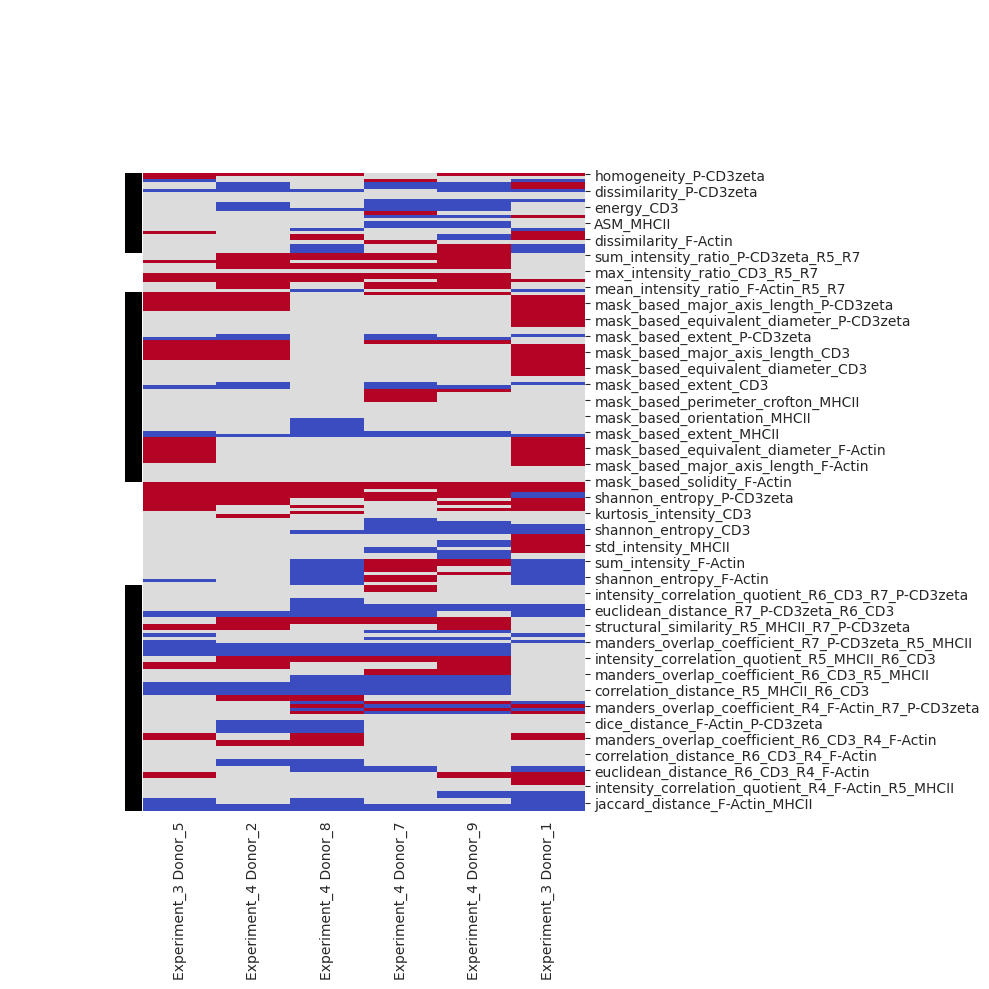

In [71]:
metadata_p_values_copy = metadata_p_values.T.copy()
feature_type_color_map = {
    'colocalization':"black", 
    'intensity statistics':"white", 
    'morphology':"black",
    'synaptic feature':"white", 
    'texture':"black"
}

row_colors = [ feature_type_color_map[f]  for f in features_series.feature_type.tolist()]

cm = sns.clustermap(metadata_p_values_copy,
               cmap="coolwarm",
                    row_colors=row_colors,
               row_cluster=False, 
               col_cluster=False,
               vmin = -1,
               vmax = 1)

cm.cax.set_visible(False)
metadata_p_values_copy.to_csv("Source Data Figure 3a.csv", index=False)
plt.savefig('Figure - clustermap cntrl vs TCB feature heatmap.svg', bbox_inches="tight")


mean_increase: 42.0 std_increase: 9.0 mean_decrease: -39.0 std_decrease: 11.0


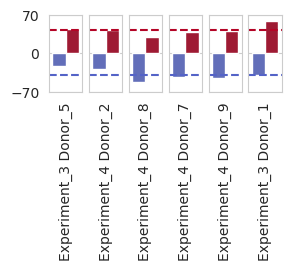

In [72]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols = len(metadata_p_values.index), 
                       nrows = 1,
                       figsize = (0.5*len(metadata_p_values.index) , 1), 
                       sharey = True)


metadata_p_values_aggregated = pd.DataFrame(columns = ["donor", "feature", "direction"])

for donor in metadata_p_values.index:
        indx = metadata_p_values.index == donor
        dummy_increase = {
            "donor": donor,
            "feature": (metadata_p_values.loc[indx,:] > 0.).sum().sum(),
            "direction": "increase"
        }
        dummy_increase = pd.DataFrame(dummy_increase,index=[0])
        metadata_p_values_aggregated = pd.concat([metadata_p_values_aggregated, dummy_increase]).reset_index(drop=True)
        
        dummy_decrease = {
            "donor": donor,
            "feature": (metadata_p_values.loc[indx,:] < 0.).sum().sum()*(-1.),
            "direction": "decrease"
        }
        dummy_decrease = pd.DataFrame(dummy_decrease,index=[0])
        metadata_p_values_aggregated = pd.concat([metadata_p_values_aggregated, dummy_decrease]).reset_index(drop=True)
        
metadata_p_values_aggregated["feature"] = metadata_p_values_aggregated["feature"].astype(float)


indx = metadata_p_values_aggregated["direction"] == "increase" 
mean_increase = metadata_p_values_aggregated.loc[indx, "feature"].mean() 
std_increase = metadata_p_values_aggregated.loc[indx, "feature"].std() 


indx = metadata_p_values_aggregated["direction"] == "decrease" 
mean_decrease = metadata_p_values_aggregated.loc[indx, "feature"].mean()
std_decrease = metadata_p_values_aggregated.loc[indx, "feature"].std()

print("mean_increase:", round(mean_increase,0),
      "std_increase:", round(std_increase,0),
      "mean_decrease:", round(mean_decrease,0),
     "std_decrease:", round(std_decrease,0))

c_lim = metadata_p_values_aggregated["feature"].abs().max() + 2.
c_lim = c_lim + 10 - (c_lim % 5)

for i, donor in enumerate(metadata_p_values.index):
    ax[i].axhline(mean_increase, c = (180/255.,4/255.,38/255.,1.), ls = "--")
    ax[i].axhline(mean_decrease, c = (84/255.,99/255.,199/255.,1.), ls = "--")
        
    indx = metadata_p_values_aggregated.donor == donor

    ax[i] = sns.barplot(data = metadata_p_values_aggregated.loc[indx,:],
                        x = "donor",
                        y = "feature", 
                        hue = "direction",
                        hue_order = ["decrease","increase"],
                        palette = [(84/255.,99/255.,199/255.,1.),(180/255.,4/255.,38/255.,1.)],
                        ax = ax[i])
    ax[i].legend().remove()
    ax[i].set_xticklabels([donor], rotation = "vertical")
    
    ax[i].set_ylim([-1*c_lim, c_lim]) 
    ax[i].set_yticks([-1*c_lim, 0,c_lim])
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")



plt.savefig('Figure - aggregated features cntrl vs TCB feature barplot.svg', bbox_inches="tight")


In [73]:
indx = metadata_p_values_aggregated["direction"] == "increase" 
metadata_p_values_aggregated.loc[indx, :]

,donor,feature,direction
0,Experiment_3 Donor_5,4.4e+01,increase
2,Experiment_4 Donor_2,4.3e+01,increase
4,Experiment_4 Donor_8,2.9e+01,increase
6,Experiment_4 Donor_7,3.8e+01,increase
8,Experiment_4 Donor_9,4.1e+01,increase
10,Experiment_3 Donor_1,5.8e+01,increase


In [74]:
indx = metadata_p_values_aggregated["direction"] == "decrease" 
metadata_p_values_aggregated.loc[indx, :]

,donor,feature,direction
1,Experiment_3 Donor_5,-2.3e+01,decrease
3,Experiment_4 Donor_2,-2.9e+01,decrease
5,Experiment_4 Donor_8,-5.2e+01,decrease
7,Experiment_4 Donor_7,-4.4e+01,decrease
9,Experiment_4 Donor_9,-4.5e+01,decrease
11,Experiment_3 Donor_1,-4.0e+01,decrease


In [75]:
## Overal postiive and negative 

print("possible changes: ", metadata_p_values.shape[0] * metadata_p_values.shape[1])
features_series.sum()


possible changes:  1188


feature                       homogeneity_P-CD3zetacorrelation_P-CD3zetacont...
feature_type                  texturetexturetexturetexturetexturetexturetext...
channel_1                     4_P-CD3zeta4_P-CD3zeta4_P-CD3zeta4_P-CD3zeta4_...
channel_2                     4_P-CD3zeta4_P-CD3zeta4_P-CD3zeta4_P-CD3zeta4_...
num_pos_significant_donors                                              2.5e+02
num_neg_significant_donors                                             -2.3e+02
num_significant_donors                                                  4.9e+02
significant_feature                                                     2.6e+02
significant_feature_2_exp                                                    92
significant_feature_1_exp                                                   170
dtype: object

In [76]:
indx = features_series.feature_type == "texture"
print("texture features",indx.sum())
indx = indx & (features_series.num_pos_significant_donors >= 4)
print("texture features for minimum 4 donors",indx.sum())
features_series.loc[indx,:].sort_values(["num_significant_donors",
                            "significant_feature_2_exp"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


texture features 25
texture features for minimum 4 donors 1


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors
0,homogeneity_P-CD3zeta,texture,5.0e+00,5.0e+00,0.0e+00


In [77]:
indx = features_series.feature_type == "texture"
print("texture features",indx.sum())
indx = indx & (features_series.num_neg_significant_donors <= -4)
print("texture features for minimum 4 donors",indx.sum())
features_series.loc[indx,:].sort_values(["num_significant_donors",
                            "significant_feature_2_exp"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


texture features 25
texture features for minimum 4 donors 2


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors
5,dissimilarity_P-CD3zeta,texture,5.0e+00,0.0e+00,-5.0e+00
11,homogeneity_CD3,texture,4.0e+00,0.0e+00,-4.0e+00


In [78]:
indx = features_series.feature_type == "synaptic feature"
print("synaptic feature features",indx.sum())
indx = indx & (features_series.num_pos_significant_donors >= 4)
print("synaptic feature features for minimum 4 donors",indx.sum())
features_series.loc[indx,:].sort_values(["num_significant_donors",], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


synaptic feature features 12
synaptic feature features for minimum 4 donors 7


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors
31,sum_intensity_ratio_MHCII_R5_R7,synaptic feature,5.0e+00,5.0e+00,0.0e+00
32,mean_intensity_ratio_MHCII_R5_R7,synaptic feature,5.0e+00,5.0e+00,0.0e+00
33,max_intensity_ratio_MHCII_R5_R7,synaptic feature,5.0e+00,5.0e+00,0.0e+00
25,sum_intensity_ratio_P-CD3zeta_R5_R7,synaptic feature,4.0e+00,4.0e+00,0.0e+00
26,mean_intensity_ratio_P-CD3zeta_R5_R7,synaptic feature,4.0e+00,4.0e+00,0.0e+00
28,sum_intensity_ratio_CD3_R5_R7,synaptic feature,4.0e+00,4.0e+00,0.0e+00
29,mean_intensity_ratio_CD3_R5_R7,synaptic feature,4.0e+00,4.0e+00,0.0e+00


In [79]:
indx = features_series.feature_type == "synaptic feature"
print("synaptic feature features",indx.sum())
indx = indx & (features_series.num_neg_significant_donors <= -4)
print("synaptic feature features for minimum 4 donors",indx.sum())
features_series.loc[indx,:].sort_values(["num_significant_donors",], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


synaptic feature features 12
synaptic feature features for minimum 4 donors 0


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors


In [80]:
indx = features_series.feature_type == "morphology"
print("morphology features",indx.sum())
indx = indx & (features_series.num_pos_significant_donors >= 4)
print("morphology features for minimum 4 donors",indx.sum())
features_series.loc[indx,:].sort_values(["num_significant_donors"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


morphology features 59
morphology features for minimum 4 donors 2


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors
37,mask_based_eccentricity_P-CD3zeta,morphology,4.0e+00,4.0e+00,0.0e+00
52,mask_based_eccentricity_CD3,morphology,4.0e+00,4.0e+00,0.0e+00


In [81]:
indx = features_series.feature_type == "morphology"
print("morphology features",indx.sum())
indx = indx & (features_series.num_neg_significant_donors <= -4)
print("morphology features for minimum 4 donors",indx.sum())
features_series.loc[indx,:].sort_values(["num_significant_donors"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


morphology features 59
morphology features for minimum 4 donors 4


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors
81,mask_based_solidity_MHCII,morphology,6.0e+00,0.0e+00,-6.0e+00
51,mask_based_solidity_P-CD3zeta,morphology,4.0e+00,0.0e+00,-4.0e+00
66,mask_based_solidity_CD3,morphology,4.0e+00,0.0e+00,-4.0e+00
80,mask_based_extent_MHCII,morphology,4.0e+00,0.0e+00,-4.0e+00


In [82]:
indx = features_series.feature_type == "intensity statistics"
print("intensity statistics features",indx.sum())
indx = indx & (features_series.num_pos_significant_donors >= 4)
print("intensity statistics features for minimum 4 donors",indx.sum())
features_series.loc[indx,:].sort_values(["num_significant_donors"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


intensity statistics features 32
intensity statistics features for minimum 4 donors 7


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors
96,mean_intensity_P-CD3zeta,intensity statistics,6.0e+00,6.0e+00,0.0e+00
97,max_intensity_P-CD3zeta,intensity statistics,6.0e+00,6.0e+00,0.0e+00
99,std_intensity_P-CD3zeta,intensity statistics,6.0e+00,5.0e+00,-1.0e+00
100,shannon_entropy_P-CD3zeta,intensity statistics,6.0e+00,5.0e+00,-1.0e+00
98,skew_intensity_P-CD3zeta,intensity statistics,5.0e+00,5.0e+00,0.0e+00
101,sum_intensity_P-CD3zeta,intensity statistics,4.0e+00,4.0e+00,0.0e+00
102,kurtosis_intensity_P-CD3zeta,intensity statistics,4.0e+00,4.0e+00,0.0e+00


In [83]:
indx = features_series.feature_type == "intensity statistics"
print("intensity statistics features",indx.sum())
indx = indx & (features_series.num_neg_significant_donors <= -4)
print("intensity statistics features for minimum 4 donors",indx.sum())
features_series.loc[indx,:].sort_values(["num_significant_donors"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


intensity statistics features 32
intensity statistics features for minimum 4 donors 1


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors
111,std_intensity_CD3,intensity statistics,4.0e+00,0.0e+00,-4.0e+00


In [84]:
indx = features_series.feature_type == "colocalization"
print("colocalization features",indx.sum())
indx = indx & (features_series.num_pos_significant_donors >= 4)
print("colocalization features for minimum 4 donors",indx.sum())
features_series.loc[indx,:].sort_values(["num_significant_donors"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


colocalization features 70
colocalization features for minimum 4 donors 4


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors
138,intensity_correlation_quotient_R5_MHCII_R7_P-C...,colocalization,4.0e+00,4.0e+00,0.0e+00
139,intensity_correlation_quotient_R7_P-CD3zeta_R5...,colocalization,4.0e+00,4.0e+00,0.0e+00
150,intensity_correlation_quotient_R5_MHCII_R6_CD3,colocalization,4.0e+00,4.0e+00,0.0e+00
151,intensity_correlation_quotient_R6_CD3_R5_MHCII,colocalization,4.0e+00,4.0e+00,0.0e+00


In [85]:
features_series.loc[indx,"feature"].values


array(['intensity_correlation_quotient_R5_MHCII_R7_P-CD3zeta',
       'intensity_correlation_quotient_R7_P-CD3zeta_R5_MHCII',
       'intensity_correlation_quotient_R5_MHCII_R6_CD3',
       'intensity_correlation_quotient_R6_CD3_R5_MHCII'], dtype=object)

In [86]:
indx = features_series.feature_type == "colocalization"
print("colocalization features",indx.sum())
indx = indx & (features_series.num_neg_significant_donors <= -4)
print("colocalization features for minimum 4 donors",indx.sum())
features_series.loc[indx,:].sort_values(["num_significant_donors"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


colocalization features 70
colocalization features for minimum 4 donors 14


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors
196,correlation_distance_R4_F-Actin_R5_MHCII,colocalization,6.0e+00,0.0e+00,-6.0e+00
197,correlation_distance_R5_MHCII_R4_F-Actin,colocalization,6.0e+00,0.0e+00,-6.0e+00
136,correlation_distance_R6_CD3_R7_P-CD3zeta,colocalization,5.0e+00,0.0e+00,-5.0e+00
137,correlation_distance_R7_P-CD3zeta_R6_CD3,colocalization,5.0e+00,0.0e+00,-5.0e+00
146,dice_distance_MHCII_P-CD3zeta,colocalization,5.0e+00,0.0e+00,-5.0e+00
147,jaccard_distance_MHCII_P-CD3zeta,colocalization,5.0e+00,0.0e+00,-5.0e+00
148,correlation_distance_R5_MHCII_R7_P-CD3zeta,colocalization,5.0e+00,0.0e+00,-5.0e+00
149,correlation_distance_R7_P-CD3zeta_R5_MHCII,colocalization,5.0e+00,0.0e+00,-5.0e+00
158,dice_distance_MHCII_CD3,colocalization,5.0e+00,0.0e+00,-5.0e+00
159,jaccard_distance_MHCII_CD3,colocalization,5.0e+00,0.0e+00,-5.0e+00


In [87]:

features_series.sort_values(["num_significant_donors"], ascending=False)[["feature",
                                                                            "feature_type",
                                                                            "num_significant_donors",
                                                    "num_pos_significant_donors",
                                                    "num_neg_significant_donors"]].head(50)


,feature,feature_type,num_significant_donors,num_pos_significant_donors,num_neg_significant_donors
99,std_intensity_P-CD3zeta,intensity statistics,6.0e+00,5.0e+00,-1.0e+00
81,mask_based_solidity_MHCII,morphology,6.0e+00,0.0e+00,-6.0e+00
196,correlation_distance_R4_F-Actin_R5_MHCII,colocalization,6.0e+00,0.0e+00,-6.0e+00
100,shannon_entropy_P-CD3zeta,intensity statistics,6.0e+00,5.0e+00,-1.0e+00
97,max_intensity_P-CD3zeta,intensity statistics,6.0e+00,6.0e+00,0.0e+00
96,mean_intensity_P-CD3zeta,intensity statistics,6.0e+00,6.0e+00,0.0e+00
197,correlation_distance_R5_MHCII_R4_F-Actin,colocalization,6.0e+00,0.0e+00,-6.0e+00
0,homogeneity_P-CD3zeta,texture,5.0e+00,5.0e+00,0.0e+00
149,correlation_distance_R7_P-CD3zeta_R5_MHCII,colocalization,5.0e+00,0.0e+00,-5.0e+00
5,dissimilarity_P-CD3zeta,texture,5.0e+00,0.0e+00,-5.0e+00


In [88]:
key_order = metadata_p_values.abs().sum(1).sort_values(ascending=True).index 


In [89]:
metadata_p_values.loc[key_order,['mask_based_eccentricity_MHCII',
                              "dissimilarity_P-CD3zeta",
                                 'mean_intensity_P-CD3zeta',
                                 'mean_intensity_F-Actin',
                                 'mean_intensity_ratio_F-Actin_R5_R7',
                                 'sum_intensity_ratio_F-Actin_R5_R7',
                                 'max_intensity_ratio_F-Actin_R5_R7',
                                 'mean_intensity_ratio_MHCII_R5_R7']]


,mask_based_eccentricity_MHCII,dissimilarity_P-CD3zeta,mean_intensity_P-CD3zeta,mean_intensity_F-Actin,mean_intensity_ratio_F-Actin_R5_R7,sum_intensity_ratio_F-Actin_R5_R7,max_intensity_ratio_F-Actin_R5_R7,mean_intensity_ratio_MHCII_R5_R7
Experiment_3 Donor_5,0.0e+00,-1.0e+00,1.0e+00,-0.0e+00,0.0e+00,0.0e+00,-0.0e+00,1.0e+00
Experiment_4 Donor_2,-0.0e+00,-1.0e+00,1.0e+00,-0.0e+00,1.0e+00,1.0e+00,-0.0e+00,1.0e+00
Experiment_4 Donor_8,0.0e+00,-1.0e+00,1.0e+00,-1.0e+00,0.0e+00,0.0e+00,-1.0e+00,1.0e+00
Experiment_4 Donor_7,1.0e+00,-0.0e+00,1.0e+00,1.0e+00,1.0e+00,1.0e+00,0.0e+00,1.0e+00
Experiment_4 Donor_9,1.0e+00,-1.0e+00,1.0e+00,0.0e+00,1.0e+00,1.0e+00,0.0e+00,1.0e+00
Experiment_3 Donor_1,0.0e+00,-1.0e+00,1.0e+00,-1.0e+00,-0.0e+00,-0.0e+00,-1.0e+00,0.0e+00


In [90]:
p_values_float.loc[key_order,['mask_based_eccentricity_MHCII',
                              "dissimilarity_P-CD3zeta",
                                 'mean_intensity_P-CD3zeta',
                                 'mean_intensity_ratio_F-Actin_R5_R7',
                                 'sum_intensity_ratio_F-Actin_R5_R7',
                                 'max_intensity_ratio_F-Actin_R5_R7',
                                 'mean_intensity_ratio_MHCII_R5_R7']].round(3)


,mask_based_eccentricity_MHCII,dissimilarity_P-CD3zeta,mean_intensity_P-CD3zeta,mean_intensity_ratio_F-Actin_R5_R7,sum_intensity_ratio_F-Actin_R5_R7,max_intensity_ratio_F-Actin_R5_R7,mean_intensity_ratio_MHCII_R5_R7
Experiment_3 Donor_5,7.1e-02,0.0e+00,0.0e+00,3.8e-01,3.8e-01,4.2e-01,3.8e-02
Experiment_4 Donor_2,6.2e-01,1.0e-03,0.0e+00,0.0e+00,0.0e+00,6.4e-01,0.0e+00
Experiment_4 Donor_8,1.5e-01,1.9e-02,0.0e+00,1.4e-01,1.4e-01,8.0e-03,0.0e+00
Experiment_4 Donor_7,1.2e-02,9.9e-01,0.0e+00,0.0e+00,0.0e+00,4.6e-01,0.0e+00
Experiment_4 Donor_9,6.0e-03,0.0e+00,0.0e+00,1.0e-03,1.0e-03,6.8e-02,0.0e+00
Experiment_3 Donor_1,9.1e-02,0.0e+00,0.0e+00,6.5e-01,6.5e-01,0.0e+00,2.7e-01


In [91]:
pd.options.display.float_format = '{:.1e}'.format

p_values_float.loc[key_order,['mask_based_eccentricity_MHCII',
                              "dissimilarity_P-CD3zeta",
                                 'mean_intensity_P-CD3zeta',
                                 'mean_intensity_ratio_F-Actin_R5_R7',
                                 'sum_intensity_ratio_F-Actin_R5_R7',
                                 'max_intensity_ratio_F-Actin_R5_R7',
                                 'mean_intensity_ratio_MHCII_R5_R7']]


,mask_based_eccentricity_MHCII,dissimilarity_P-CD3zeta,mean_intensity_P-CD3zeta,mean_intensity_ratio_F-Actin_R5_R7,sum_intensity_ratio_F-Actin_R5_R7,max_intensity_ratio_F-Actin_R5_R7,mean_intensity_ratio_MHCII_R5_R7
Experiment_3 Donor_5,7.1e-02,1.5e-06,7.7e-20,3.8e-01,3.8e-01,4.2e-01,3.8e-02
Experiment_4 Donor_2,6.2e-01,5.8e-04,8.7e-11,2.4e-04,2.4e-04,6.4e-01,1.5e-07
Experiment_4 Donor_8,1.5e-01,1.9e-02,7.2e-08,1.4e-01,1.4e-01,7.6e-03,1.9e-04
Experiment_4 Donor_7,1.2e-02,9.9e-01,3.3e-08,3.9e-05,3.9e-05,4.6e-01,3.8e-05
Experiment_4 Donor_9,6.2e-03,2.2e-04,4.8e-12,9.1e-04,9.1e-04,6.8e-02,1.9e-05
Experiment_3 Donor_1,9.1e-02,1.8e-22,5.7e-24,6.5e-01,6.5e-01,1.0e-04,2.7e-01


In [92]:
features_series_to_be_saved = features_series.copy()
features_series_to_be_saved.index = features_series_to_be_saved["feature"]
indx = features_series_to_be_saved["num_pos_significant_donors"] > 3
indx = indx | (features_series_to_be_saved["num_neg_significant_donors"] < -3)
cols = ["feature_type"]
features_series_to_be_saved = pd.merge(features_series_to_be_saved.sort_values(["num_significant_donors","feature_type"], ascending=False).loc[indx,cols], 
         metadata_p_values.T, 
         left_index = True, 
         right_index = True).round(0)

new_cols = dict()
for col in metadata_p_values.index.values:
    new_cols[col] = col.replace("xperiment_","").replace("onor_","") 
features_series_to_be_saved = features_series_to_be_saved.rename(columns = new_cols )

features_series_to_be_saved.sort_values(["feature_type"], ascending=False).to_csv("TCD-CD19_comparison_top_features.csv")


In [93]:

indx = (metadata["prediction"].isin([ "Synapses_with_signaling"])) # "Synapses_without_signaling",
indx = indx&(metadata["outlier"].isin([0]))
indx = indx&(metadata["condition"].isin(["DIG-TCB", "CD19-TCB"]))
#indx = indx[indx].sample(4000).index
cols_features = ['mask_based_eccentricity_MHCII',"dissimilarity_P-CD3zeta",
                                 'mean_intensity_P-CD3zeta',
                                 'mean_intensity_ratio_F-Actin_R5_R7',
                                 'mean_intensity_ratio_MHCII_R5_R7']
cols_metadata = [ "condition", "key", "object_number"]

df_visualization =  pd.concat([df_features.loc[indx,cols_features], metadata.loc[indx,cols_metadata]], axis=1 ).copy()


for k in df_visualization.key.unique():
    indx = df_visualization.key == k
    for col in cols_features:
        min_ = df_visualization.loc[indx,col].quantile(0.05)
        max_ = df_visualization.loc[indx,col].quantile(0.95)
        df_visualization.loc[indx,col] = (df_visualization.loc[indx,col] -  min_)/ (max_ - min_)

for col in cols_features:
    df_visualization.loc[df_visualization.loc[:,col] >= 1.,col] = 1.
    df_visualization.loc[df_visualization.loc[:,col] <= 0.,col] = 0.


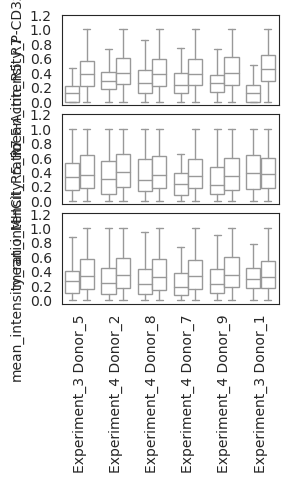

In [94]:
sns.set_style("white")

fig, ax  = plt.subplots(3,1,figsize = (0.4*7,1.25*3),sharex = True)

col = 'mean_intensity_P-CD3zeta'
ax[0] = sns.boxplot(data=df_visualization , 
                    x = "key", 
                    order = key_order,
                    linewidth = 1.,
                    dodge=True,
                    y= col, 
                    showfliers = False,
                    hue_order =["DIG-TCB", "CD19-TCB"],
                    palette =["white", "white"],
                    hue = "condition",
                  ax = ax[0])  
ax[0].legend().remove() 
ax[0].set_xlabel("")   
ax[0].set_yticks([0.,0.2,0.4,0.6,0.8,1.0,1.2])  

col = 'mean_intensity_ratio_F-Actin_R5_R7' 
ax[1] = sns.boxplot(data=df_visualization , 
                    x = "key", 
                    order = key_order,
                    linewidth = 1.,
                    dodge=True,
                    y= col, 
                    showfliers = False,
                    hue_order =["DIG-TCB", "CD19-TCB"],
                    palette =["white", "white"],
                    hue = "condition",
                  ax = ax[1])    
ax[1].legend().remove()
ax[1].set_xlabel("")   
ax[1].set_yticks([0.,0.2,0.4,0.6,0.8,1.0,1.2])  

col = 'mean_intensity_ratio_MHCII_R5_R7'
ax[2] = sns.boxplot(data=df_visualization , 
                    x = "key", 
                    order = key_order,
                    linewidth = 1.,
                    dodge=True,
                    y= col, 
                    showfliers = False,
                    hue_order =["DIG-TCB", "CD19-TCB"],
                    palette =["white", "white"],
                    hue = "condition",
                  ax = ax[2])  
ax[2].legend().remove()
ax[2].set_xlabel("")   
ax[2].set_yticks([0.,0.2,0.4,0.6,0.8,1.0,1.2])  

ax[2].set_xticklabels(key_order, rotation = "vertical")


for i in range(3):
    for _, patch in enumerate(ax[i].artists):
    # Boxes from left to right
        hatch = next(hatches)
        patch.set_hatch(hatch)

        
fig.subplots_adjust(hspace=0.1, wspace= 0.1) 
plt.savefig('Figure - Boxplot cntrl vs TCB synapses with signaling.svg', bbox_inches="tight")


In [95]:
df_visualization.to_csv("Source Data Figure 3b-d-f.csv", index=False)

[536.0, 5.0, 27.0, 38.0, 48.0, 40.0] [1075.0, 99.0, 609.7700000000004, 2128.1899999999987, 1186.21, 73.0]


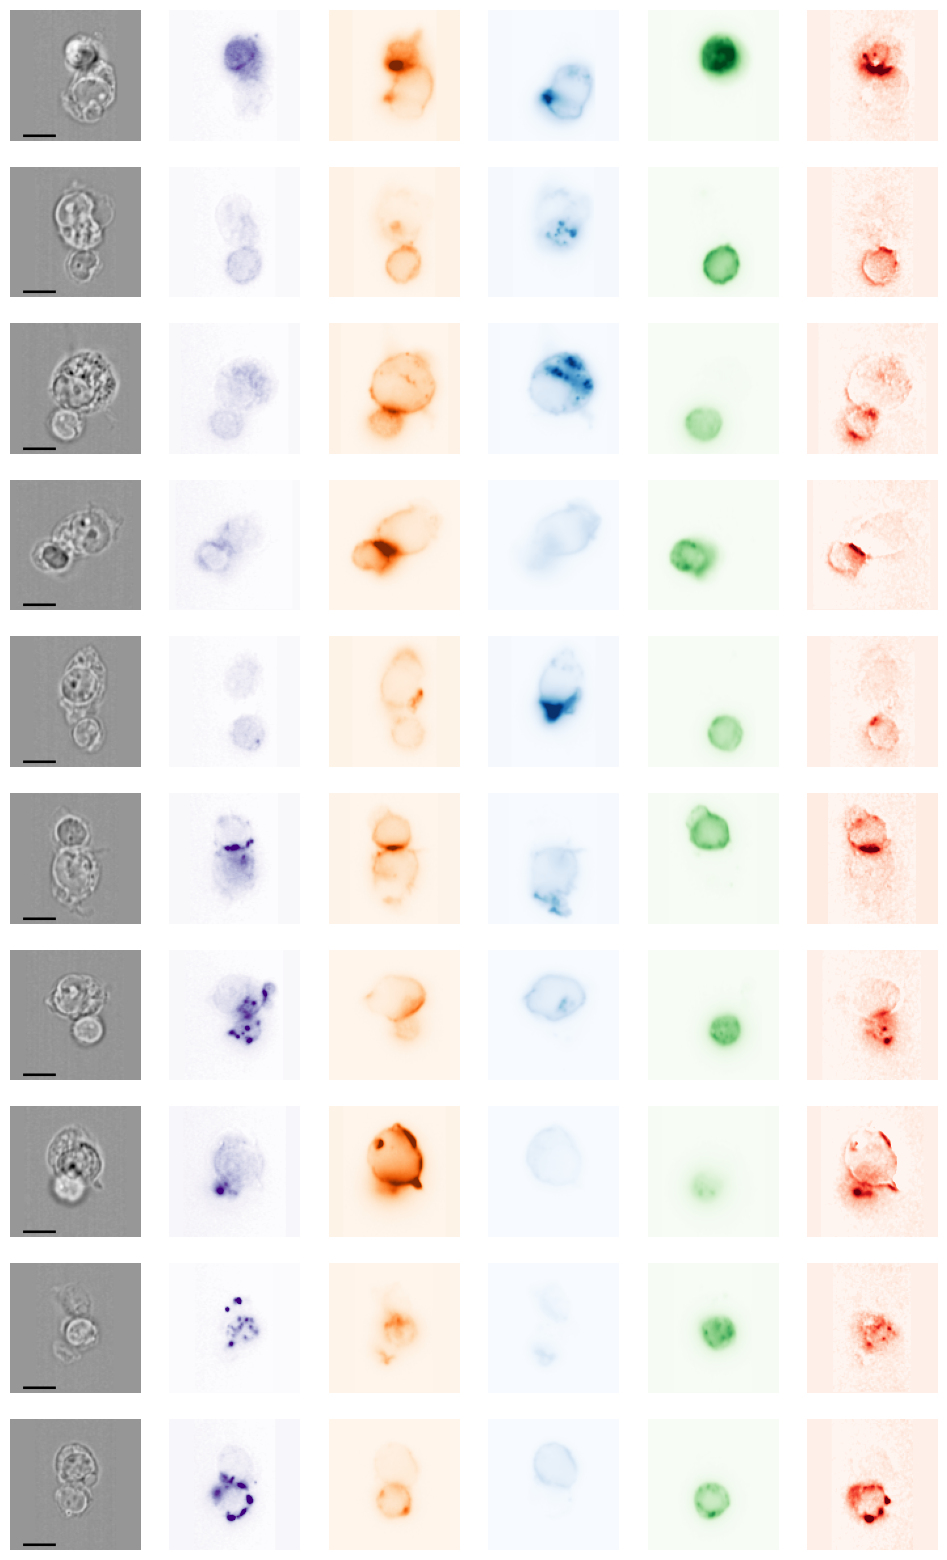

In [96]:
k = 5 
image_size = 100
channels_to_be_plotted = [0,1,3,4,5,6]
channel_colors = ["Greys","Purples","Oranges" ,"Blues", "Greens","Reds"]
# indx1 = metadata["donor"] == "Donor_9"
# indx1 = indx1&(metadata["experiment"] == "Experiment_4")
# indx1 = indx1&(metadata["prediction"].isin(["Synapses_with_signaling"])) # Synapses
# indx1 = indx1&(metadata["outlier"].isin([0]))
# indx1 = indx1&(metadata["condition"].isin(["DIG-TCB" ]))
# indx1 = indx1[indx1].sample(k).index.tolist()


# indx2 = metadata["donor"] == "Donor_9"
# indx2 = indx2&(metadata["experiment"] == "Experiment_4")
# indx2 = indx2&(metadata["prediction"].isin(["Synapses_with_signaling"])) 
# indx2 = indx2&(metadata["outlier"].isin([0])) 
# indx2 = indx2&(metadata["condition"].isin(["CD19-TCB" ]))
# indx2 = indx2[indx2].sample(k).index.tolist()


indx1 = [1050216, 1063984, 1065826, 1055277,1050208]
indx1 = sorted(indx1)
indx2 = [1010655,1025869,  1021735,1018919,1012753] 
indx2 = sorted(indx2)


files = metadata.loc[indx1+indx2,:].sort_values("object_number")["file"].tolist()

nrows = 2*k
ncols = len(channels_to_be_plotted)

fix,ax = plt.subplots(nrows, ncols, figsize = ( ncols*2, nrows*2 ))
    
vmin = [4095.]*ncols
vmax = [0.]*ncols

for i in range(nrows):
    h5_file_ = h5py.File(files[i].replace("/pstore/data/DS4/", "/projects/site/pred/data_science/year/2022/immunological_synapse/"), "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for j, ch in enumerate(channels_to_be_plotted):
        if j>0:
            vmin[j] = min(vmin[j], np.quantile(image[:,:,ch], 0.40)  )
            vmax[j] = max(vmax[j], np.quantile(image[:,:,ch], 0.99)  )
        else:
            vmin[j] = min(vmin[j], np.quantile(image[:,:,ch], 0.0)  )
            vmax[j] = max(vmax[j], np.quantile(image[:,:,ch], 1.0)  )

        
print(vmin,vmax)
for i in range(nrows):
    h5_file_ = h5py.File(files[i].replace("/pstore/data/DS4/", "/projects/site/pred/data_science/year/2022/immunological_synapse/"), "r")
    image = h5_file_.get("image")[()]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    for j, ch in enumerate(channels_to_be_plotted):
            image_dummy = crop(image[:,:,ch], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values=np.median(image_dummy) )
            if j == 0:
                image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] = vmax[j]
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].axis('off')
    h5_file_.close()

plt.savefig('Figure - sample images cd19 vs dig synapses.svg', bbox_inches="tight")


In [97]:

indx = metadata.file.isin(files)
object_numbers =  metadata.loc[indx,"object_number"]
metadata.loc[indx,:].sort_values("object_number")


,file,experiment,donor,condition,object_number,set,label,prediction,entropy,key,outlier,cluster
1055277,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,68837,unlabeled,-1,Synapses_with_signaling,2.5e-02,Experiment_4 Donor_9,0,1
1063984,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,69853,unlabeled,-1,Synapses_with_signaling,3.2e-02,Experiment_4 Donor_9,0,1
1065826,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,80819,unlabeled,-1,Synapses_with_signaling,8.3e-02,Experiment_4 Donor_9,0,1
1050208,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,93377,unlabeled,-1,Synapses_with_signaling,2.6e-01,Experiment_4 Donor_9,0,1
1050216,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,DIG-TCB,101796,unlabeled,-1,Synapses_with_signaling,1.1e-01,Experiment_4 Donor_9,0,1
1021735,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,CD19-TCB,131006,unlabeled,-1,Synapses_with_signaling,1.7e-03,Experiment_4 Donor_9,0,1
1025869,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,CD19-TCB,152745,unlabeled,-1,Synapses_with_signaling,2.0e-02,Experiment_4 Donor_9,0,1
1012753,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,CD19-TCB,153170,unlabeled,-1,Synapses_with_signaling,6.7e-02,Experiment_4 Donor_9,0,1
1010655,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,CD19-TCB,153224,unlabeled,-1,Synapses_with_signaling,7.4e-01,Experiment_4 Donor_9,0,1
1018919,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,CD19-TCB,166999,unlabeled,-1,Synapses_with_signaling,6.7e-02,Experiment_4 Donor_9,0,1


In [98]:
indx = df_visualization.key == "Experiment_4 Donor_9"
indx = indx & (df_visualization.object_number.isin(object_numbers) )
df_visualization.loc[indx,:].sort_values("object_number").round(2)


,mask_based_eccentricity_MHCII,dissimilarity_P-CD3zeta,mean_intensity_P-CD3zeta,mean_intensity_ratio_F-Actin_R5_R7,mean_intensity_ratio_MHCII_R5_R7,condition,key,object_number
1055277,5.9e-01,4.2e-01,6.6e-01,4.0e-01,3.1e-01,DIG-TCB,Experiment_4 Donor_9,68837
1063984,4.2e-01,6.7e-01,3.8e-01,1.1e-01,1.0e-01,DIG-TCB,Experiment_4 Donor_9,69853
1065826,1.0e-01,6.1e-01,3.1e-01,1.1e-01,0.0e+00,DIG-TCB,Experiment_4 Donor_9,80819
1050208,8.9e-01,4.2e-01,7.0e-02,1.0e+00,7.2e-01,DIG-TCB,Experiment_4 Donor_9,93377
1050216,8.4e-01,5.0e-01,1.6e-01,9.0e-02,3.4e-01,DIG-TCB,Experiment_4 Donor_9,101796
1021735,7.1e-01,3.3e-01,5.3e-01,2.1e-01,5.0e-02,CD19-TCB,Experiment_4 Donor_9,131006
1025869,5.2e-01,3.5e-01,5.5e-01,2.5e-01,2.4e-01,CD19-TCB,Experiment_4 Donor_9,152745
1012753,2.5e-01,1.0e+00,6.0e-01,3.9e-01,4.6e-01,CD19-TCB,Experiment_4 Donor_9,153170
1010655,1.0e+00,7.7e-01,5.0e-01,5.9e-01,4.3e-01,CD19-TCB,Experiment_4 Donor_9,153224
1018919,4.8e-01,3.0e-02,8.9e-01,4.7e-01,2.6e-01,CD19-TCB,Experiment_4 Donor_9,166999
